# Проект HR-аналитика

**Заказчик**: HR-аналитики компании «Работа с заботой».
**Цель проекта**: снижение финансовых потерь и оттока сотрудников путем управления уровнем удовлетворенности сотрудников компании и снижения рисков внезапных увольнений.

Для достижения цели необходимо посредством машинного обучения обеспечить выполнение следующих задач:
1. Предсказание уровня удовлетворённости сотрудника. Необходимо подобрать модель машинного обучения, качество которой удовлетворяет критерию SMAPE ≤ 15 на тестовой выборке.
2. Предсказание увольнения сотрудника из компании. Необходимо подобрать модель машинного обучения, качество которой удовлетворяет критерию ROC-AUC ≥ 0.91 на тестовой выборке

In [1]:
# Установка библиотек
!pip install phik -q
!pip install scikit-learn==1.4.0 -q
!pip install matplotlib==3.5 -q
!pip install shap -q
!pip install imbalanced-learn -q

In [2]:
# Импорт необходимых библиотек, классов и функций
import time
from warnings import simplefilter
from typing import Union, Optional

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik
import shap
from scipy.stats import shapiro
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from imblearn.over_sampling import RandomOverSampler, SMOTENC

In [3]:
# Определение констант
LEVEL = ["junior", "middle", "sinior"] # заменить sinior если будет исправлено на senior
WORKLOAD = ["low", "medium", "high"]
NO_YES = ["no", "yes"]

RANDOM_STATE = 42

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [4]:
train_job = pd.read_csv("https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv")
train_job.info()
train_job

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


  Файл `train_job_satisfaction_rate` содержит сведения о сотрудниках, полученные в результате опроса. Сведения содержат 9 признаков со следующими значениями:
  - `id` — уникальный идентификатор сотрудника;
  - `dept` — отдел, в котором работает сотрудник;
  - `level` — уровень занимаемой должности;
  - `workload` — уровень загруженности сотрудника;
  - `employment_years` — длительность работы в компании (в годах);
  - `last_year_promo` — показывает, было ли повышение за последний год;
  - `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
  - `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
  - `salary` — ежемесячная зарплата сотрудника;
  - `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

  Общее количество записей составляет 4000, имеются пропуски по признакам `dept` (3994 значения) и `level` (3996 значений)

In [5]:
test_data = pd.read_csv("https://code.s3.yandex.net/datasets/test_features.csv")
test_data.info()
test_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400


Файл `test_features.csv` предоставлен в качестве тестовой выборки для моделей и содержит аналогичные сведения о сотрудниках. Общее количество записей - 2000, также имеются пропуски по признакам `dept` (1998 записей) и `level` (1999 записей).

In [6]:
test_target_job = pd.read_csv("https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv")
test_target_job.info()
test_target_job

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
...,...,...
1995,405257,0.28
1996,370925,0.21
1997,857722,0.39
1998,303402,0.26


Файл `test_target_job_satisfaction_rate` содержит целевой признак для тестовой выборки. Здесь заметно, что `id` сотрудников не совпадают с таковыми в тестовой выборке, вероятно данные получены независимо и поэтому не совпадают построчно.

#### Промежуточные выводы

Проведена загрузка исходных данных, данные разделены на три файла:

1. Тренировочная выборка с данными по результатам опроса сотрудников. Данные содержат 4000 записей, по 10 признаков для каждой. Имеются пропуски по признаку `dept` - 6 значений и признаку `level` 4 значения.
2. Тестовая выборка с аналогичными данными по сотрудникам без целевого признака. Данные содержат 2000 записей. Также имеются пропуски по признаку `dept` - значения и признаку `level` - 1 значение.
3. Целевое значение тестовой выборки с уровнем удовлетворенности сотрудников - 2000 записей. Пропуски отсутствуют.

### Предобработка данных

#### Тренировочные данные

Оценим наличие явных и неявных дубликатов

In [7]:
# Фукнция вывода количества полных дубликатов и уникальных категориальных признаков
def show_duplicates(data, qual_cols):
    print(f"Количество явных дубликатов: {data.duplicated().sum()}")
    print("\nУникальные значения по категориальным признакам")
    for i in qual_cols:
        print(f"По признаку '{i}':", end=" ")
        print(data[i].unique())

# Категориальные признаки
qual_columns = ["dept", "level", "workload", "last_year_promo", "last_year_violations"]
print("Дубликатов по ID:", train_job["id"].duplicated().sum())
show_duplicates(train_job, qual_columns)

Дубликатов по ID: 0
Количество явных дубликатов: 0

Уникальные значения по категориальным признакам
По признаку 'dept': ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
По признаку 'level': ['junior' 'middle' 'sinior' nan]
По признаку 'workload': ['medium' 'high' 'low']
По признаку 'last_year_promo': ['no' 'yes']
По признаку 'last_year_violations': ['no' 'yes']


Явные дубликаты отсутствуют. Также отсутствуют неявные дубликаты по значениям категориальных признаков, однако имеются опечатки по признаку `level` - вместо `senior` указано `sinior` необходимо проверить какие данные присутствуют в тестовой выборке. Если различаются, то этот момент требует исправления. Также на будущее, лучше данный вопрос отработать с HR-аналитиками, так как в будущем любые изменения в написании, в том числе опечаток, могут повлиять на модель.

Оценим числовые признаки.

In [8]:
# Списки количественных признаков
quant_columns = ["employment_years", "supervisor_evaluation", 
                 "salary"]
target_column_job = ["job_satisfaction_rate"]

train_job[quant_columns + target_column_job].describe(
    [0.0012, 0.01, 0.25, .5, 0.75, .99, .9988]
).T.drop(columns="count").style.format("{:,.2f}") \
.background_gradient(cmap=sns.diverging_palette(250, 25, s=100, l=50, as_cmap=True), axis=1)

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
employment_years,3.72,2.54,1.00,1.00,1.00,2.00,3.00,6.00,10.00,10.00,10.00
supervisor_evaluation,3.48,1.01,1.00,1.00,1.00,3.00,4.00,4.00,5.00,5.00,5.00
salary,"33,926.70","14,900.70","12,000.00","12,000.00","12,000.00","22,800.00","30,000.00","43,200.00","78,012.00","94,800.00","98,400.00"
job_satisfaction_rate,0.53,0.23,0.03,0.04,0.08,0.36,0.56,0.71,0.93,0.99,1.00


По числовым признакам также нет очень больших отклонений.

Проверим пропущенные значения

In [9]:
train_job.query("dept.isna() or level.isna()")

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Пропуски встречаются только в одном столбце по каждому сотруднику, это хорошо, так как можно подобрать значения с близкой заработной платой по отделу или уровню занимаемой должности. Возможно при выгрузке возникли какие-либо сбои или опрос позволяет не выбирать определенные значения.

#### Тестовые данные

In [10]:
show_duplicates(test_data, qual_columns)

Количество явных дубликатов: 0

Уникальные значения по категориальным признакам
По признаку 'dept': ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
По признаку 'level': ['junior' 'middle' 'sinior' nan]
По признаку 'workload': ['medium' 'low' 'high' ' ']
По признаку 'last_year_promo': ['no' 'yes']
По признаку 'last_year_violations': ['no' 'yes']


В тестовой выборке заметно, что кроме пропущенного значения `nan` имеются также пустые значения `' '` по признакам `dept` и `workload`. Очевидно, что это также пропущенные значения по признакам. Желательно совместно с HR-аналитиками выяснить причину появления пустых значений в выборках и устранить возможные сбои для снижения вероятности возникновения проблем с моделями в будущем.

Оценим пропущенные значения.

In [11]:
test_data.query("dept.isna() or level.isna() or dept == ' ' or workload == ' '")

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


Пропущенных значений, в том числе значений `' '` немного по тренировочной выборке.

Оценим числовые признаки.

In [12]:
test_data[quant_columns].describe(
    [0.0012, 0.01, 0.25, .5, 0.75, .99, .9988]
).T.drop(columns="count").style.format("{:,.2f}") \
.background_gradient(cmap=sns.diverging_palette(250, 25, s=100, l=50, as_cmap=True), axis=1)

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
employment_years,3.67,2.54,1.00,1.00,1.00,1.00,3.00,6.00,10.00,10.00,10.00
supervisor_evaluation,3.53,1.00,1.00,1.00,1.00,3.00,4.00,4.00,5.00,5.00,5.00
salary,"34,066.80","15,398.44","12,000.00","12,000.00","12,000.00","22,800.00","30,000.00","43,200.00","81,600.00","94,800.00","96,000.00"


Аномалий не выявлено. Проверим значения целевого признака тестовой выборки.

In [13]:
test_target_job["job_satisfaction_rate"].to_frame().describe(
    [0.0012, 0.01, 0.25, .5, 0.75, .99, .9988]
).T.drop(columns="count").style.format("{:,.2f}") \
.background_gradient(cmap=sns.diverging_palette(250, 25, s=100, l=50, as_cmap=True), axis=1)

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
job_satisfaction_rate,0.55,0.22,0.03,0.05,0.09,0.38,0.58,0.72,0.94,1.00,1.00


По числовым признакам тестовой выборки также отсутствуют аномальные значения. 

Так как в тестовой выборке и целевом признаке порядок id сотрудников не совпадает, отсортируем две таблицы по id и проверим соответствие двух датасетов.

In [14]:
# Сортировка датасетов по id
test_data = test_data.sort_values(by="id").set_index("id")
test_target_job = test_target_job.sort_values(by="id").set_index("id")

# Проверка полного соответствия id по двум датасетам
print(
    "ID сотрудников в тестовой выборке полностью идентичны:",
    test_data.index.equals(test_target_job.index)
)

ID сотрудников в тестовой выборке полностью идентичны: True


Произведена сортировка датасетов с тестовыми даными и тестовым целевым признаком. Расхождения по id не выявлены.

#### Заполнение пропусков

Необходимо заполнить пропущенные значения датасетов. Для заполнения пропусков необходимо сравнить c сотрудниками, имеющими аналогичными или близкими значения других признаков. Для этих целей должен быть хорошо применим метод k ближайших соседей.

In [15]:
# Как я понимаю проще было бы попробовать IterativeImputer но решил сделать свой на базе kNN
# Для заполнения с помощью KNNImputer необходимо кодировать категориальные признаки
# так как KNNImputer принимает только числовые значения

# Долго мучался с OneHotEncoder, понял что он не подходит - нет пропусков после кодирования, 
# KNNImputer не отрабатывает решил переделать на OrdinalEncoder.

# Для списка категорий отсортировал отделы по средней зарплате,
# чтобы была хоть какая-то упорядоченность по данному признаку

job_categories = [
    train_job.groupby("dept")["salary"].median().sort_values().index.to_list(),
    LEVEL,
    WORKLOAD,
    NO_YES,
    NO_YES
]

# Класс для обработки пропусков
class KnnImputer(BaseEstimator, TransformerMixin):
    def __init__(self, string_cols, categories, n_neighbors: int = 5):  # Инициализация параметров
        self.string_cols = string_cols
        self.categories = categories
        self.n_neighbors = n_neighbors
        self.ord = OrdinalEncoder(
            categories=categories, 
            handle_unknown="use_encoded_value",
            unknown_value=np.nan
        )
        self.knn = KNNImputer(
            n_neighbors=self.n_neighbors
        )
        self.fit_cols = None
    
    # функция для подготовки данных перед заполнением
    def _prepare_data(self, X:pd.DataFrame):
        # OHE кодирование и объединение данных, вывод данных и столбцов
        return np.append(
            self.ord.transform(X[self.string_cols]),
            X.drop(columns=self.string_cols),
            axis=1
        ), self.string_cols + [x for x in X.columns if x not in self.string_cols]

    def fit(self, X: pd.DataFrame, y=None):  # Метод fit
        # сохранение столбцов для дальнейшего использования
        self.fit_cols = X.columns
        # обучение OHE Encoder
        self.ord.fit(X[self.string_cols])
        data, _ = self._prepare_data(X)
        # обучение KNN Imputer
        self.knn.fit(data)
        return self

    def transform(self, X: pd.DataFrame, y=None):  # Метод transform
        # проверка столбцов на соответствие
        if self.fit_cols is None:
            raise Exception("This instance is not fitted yet")
        if not (self.fit_cols.equals(X.columns)):
            print("fit columns:", self.fit_cols)
            print("data columns:", X.columns)
            raise Exception(
                "Fit columns:", self.fit_cols,
                " and transform columns:", X.columns,
                " must be the same")
        data, cols = self._prepare_data(X)
        data = self.knn.transform(data)
        data = np.append(
            self.ord.inverse_transform(
                data[:,:len(self.string_cols) - len(X.columns)].round()
            ),
            data[:,len(self.string_cols) - len(X.columns):],
            axis=1
        )
        return pd.DataFrame(
            data, index=X.index, columns=cols
        ).apply(
            lambda x: x.astype(X[x.name].dtype), axis=0
        )[X.columns]

knn_imputer = KnnImputer(qual_columns, job_categories)

# Пайплайн для заполнения пропущенных значений
imputer_pipe = Pipeline(
    [('imputer', knn_imputer)]
)

# списки пропущенных значений выборок для проверки
job_missed_id = [
    train_job.query("dept.isna() or level.isna()")["id"].to_list(),
    test_data.query(
        "dept.isna() or level.isna() or dept == ' ' or workload == ' '"
    ).index.to_list()
]

In [16]:
# заполнение тестовой выборки
train_job = imputer_pipe.fit_transform(
    train_job.set_index("id").drop(columns=["job_satisfaction_rate"])
).join(train_job.set_index("id")["job_satisfaction_rate"])

# проверка заполнения пропущенных значений в тренировочной и тестовой выборках
print("Заполнение пропусков в тренировочной выборке:")
display(train_job.loc[job_missed_id[0]])
print("Заполнение пропусков в тестовой выборке:")
display(imputer_pipe.transform(test_data).loc[job_missed_id[1]])

Заполнение пропусков в тренировочной выборке:


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
631073,sales,junior,medium,1,no,no,4,27600,0.66
416327,sales,junior,low,1,no,no,5,18000,0.73
694746,purchasing,junior,medium,5,no,no,4,21600,0.62
814624,purchasing,junior,medium,3,no,no,4,24000,0.88
475114,marketing,junior,high,4,no,no,4,31200,0.63
135043,sales,junior,medium,1,no,no,3,26400,0.30
998838,sales,junior,medium,1,no,no,5,27600,0.71
497243,hr,junior,medium,1,no,no,3,26400,0.28
168668,hr,junior,low,3,no,no,4,18000,0.88


Заполнение пропусков в тестовой выборке:


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
471990,sales,junior,low,1,no,no,3,12000
590867,marketing,junior,low,4,no,no,4,28800
609865,sales,junior,medium,1,no,no,1,20400
822186,purchasing,middle,medium,3,no,no,4,38400
832342,purchasing,junior,medium,1,no,no,4,28800


Пропуски в тренировочной выборке заполнены методом k ближайших соседей, а также проведена проверка заполнения пропусков в тестовой.

#### Промежуточные выводы

Проведена предобработка данных, в рамках которой:
1. Явные и скрытые дубликаты, а также аномальные значения не обнаружены.
2. Выявлена опечатка по признаку `level` - некорректно записано значение `sinior`, необходимо данный вопрос отработать, так как в случае исправления опечатки в будущем, модели не будут адекватно воспринимать исправленное значение. В настоящем проекте значение оставлено как есть. При необходимости изменения исправить константу `LEVEL`.
3. Произведено заполнение пропущенных значений посредством пайплайна на основе метода k ближайших соседей.

### Исследовательский анализ данных

In [17]:
# Функция для вывода линейчатых диаграмм 
def show_barh(
    data: Union[pd.Series, pd.DataFrame], title: str, ylabel: str, 
    xlabel: str ="Количество", columns: Optional[str] = None, show: bool = True,
    figsize: tuple = (14, 2), ax = None, percent: bool = True, counts: bool = True,
    large_text = True
):
    # Если нужно рассчитать значения
    if counts:
        # Если данные Series, то считаем количество значений с сортировкой
        if isinstance(data, pd.Series):
            data = data.rename(ylabel).value_counts().sort_values().rename(xlabel).to_frame()
        # В противном случае нужно передавать pivot_table по необходимым параметрам
        else:
            data = data.rename_axis(ylabel).rename_axis(columns, axis=1)
            data["sum"] = data.sum(axis=1)
            data = data.sort_values(by="sum").drop(columns="sum")
    data.plot(kind="barh", figsize=figsize, legend=(data.shape[1] > 1), ax=ax)
    if large_text:
        d = 1
    else:
        d = 0
    plt.title(title, size=14+d*4, color="C0")
    plt.xlabel(xlabel, size=10+d*4)
    plt.ylabel(ylabel, size=10+d*4)
    if(plt.gca().get_legend() != None):
        plt.legend(bbox_to_anchor=(1, 1))
    if percent:
        if len(data.T) > 1:
            data = data.T.iloc[::-1,::-1]
        desc = (data / data.sum()).iloc[::-1].T.style.format("{:.1%}")
    else:
        desc = data.T.iloc[:,::-1]
    if show:
        plt.tight_layout()
        plt.show()
        display(desc)
    else:
        return desc
    

# Функция для вывода гистограмм
def show_hist(
    data: Union[pd.Series, pd.DataFrame], title: str, xlabel: str, 
    ylabel: str = "Количество", columns: Optional[str] = None, 
    bins: int = 50, figsize: tuple = (14, 6), alpha: float = 1, 
    stacked: bool = True, boxplot: bool = True
):
    if isinstance(data, pd.Series):
        data = data.rename(xlabel).to_frame()
    else:
        data = data.rename_axis(columns, axis=1)
    fig = plt.figure(figsize=figsize)
    if boxplot:
        gs = fig.add_gridspec(
            2, 1, height_ratios=[3, len(data.columns)]
        )
        ax0 = fig.add_subplot(gs[0,0])
        ax1 = fig.add_subplot(gs[1,0])
        data.boxplot(vert=False, ax=ax1)
        if (len(data.columns) == 1):
            yticks = ax1.get_yticks()
            ax1.set_yticks(yticks, labels=[""])
    else:
        ax0 = plt.gca()
    ax0.hist(data, bins=bins, alpha=alpha, 
             stacked=stacked)
    if data.shape[1] > 1:
        ax0.legend(data.columns)
    ax0.grid()
    ax0.set_ylabel(ylabel, size=16)
    plt.suptitle(title, size=18, color="C0")
    plt.xlabel(xlabel, size=16)
    plt.tight_layout()
    plt.show()
    desc = data.describe().T
    # Тест Шапиро-Уилка для проверки нормальности
    for col in data.columns:
        stat, p = shapiro(data[col].dropna())
        if p > 0.05:
            desc.loc[col, "Gaussian"] = "Probably"
        else:
            desc.loc[col, "Gaussian"] = "Probably NOT"
        desc.loc[col, "p_value"] = p
    display(desc[::-1])

#### Количественные признаки

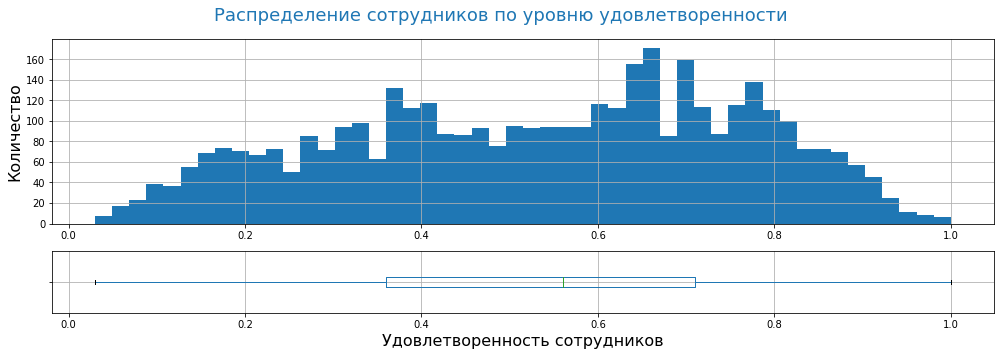

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Удовлетворенность сотрудников,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0,Probably NOT,8.905443e-28


In [18]:
show_hist(
    train_job["job_satisfaction_rate"],
    "Распределение сотрудников по уровню удовлетворенности", 
    "Удовлетворенность сотрудников", 
    figsize=(14, 5), boxplot=True
)

Уровень удовлетворенности сотрудников в основном распологается в пределах от 0.36 до 0.71, имеется небольшая бимодальность в данных. Данные скорее всего не распределены нормально.

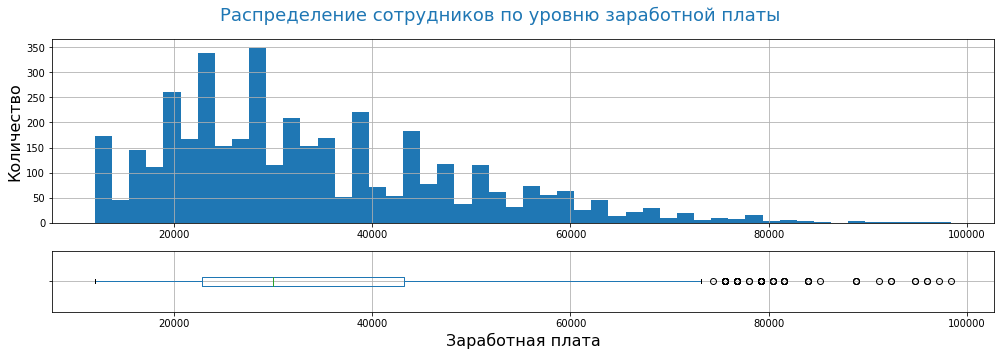

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Заработная плата,4000.0,33926.7,14900.703838,12000.0,22800.0,30000.0,43200.0,98400.0,Probably NOT,8.396205e-38


In [19]:
show_hist(
    train_job["salary"],
    "Распределение сотрудников по уровню заработной платы", 
    "Заработная плата",
    figsize=(14, 5), boxplot=True
)

Уровень заработной платы основной массы сотрудников располагается в пределах 22'800 - 43'200. Медианная заработная плата - 30'000, минимальная - 12'000, максимальная - 98'400. Распределение имеет правое отклонение в сторону более высоких зарплат. Имеются отдельные пики по количеству работников, вероятно по причине наличия зарплатной сетки.

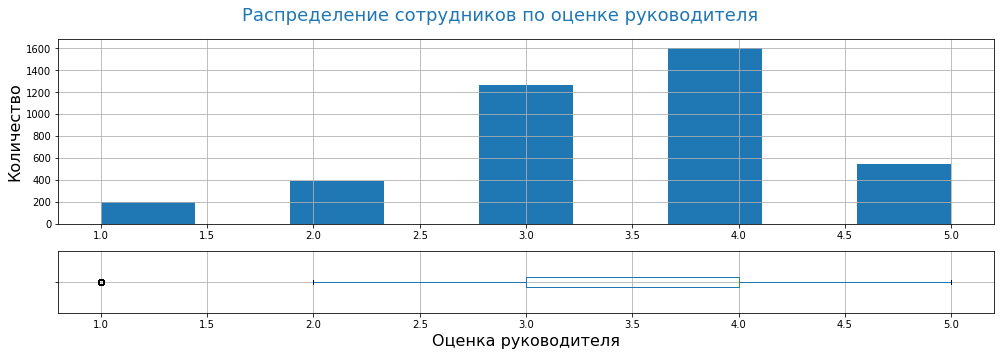

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Оценка руководителя,4000.0,3.4765,1.008812,1.0,3.0,4.0,4.0,5.0,Probably NOT,0.0


In [20]:
show_hist(
    train_job["supervisor_evaluation"],
    "Распределение сотрудников по оценке руководителя", 
    "Оценка руководителя", bins=9,
    figsize=(14, 5), boxplot=True
)

Оценки руководителей для основной массы сотрудников располагаются от 3 до 4. Распределение имеет левосторонее распределение, больше всего сотрудников имеющих оценку 4.

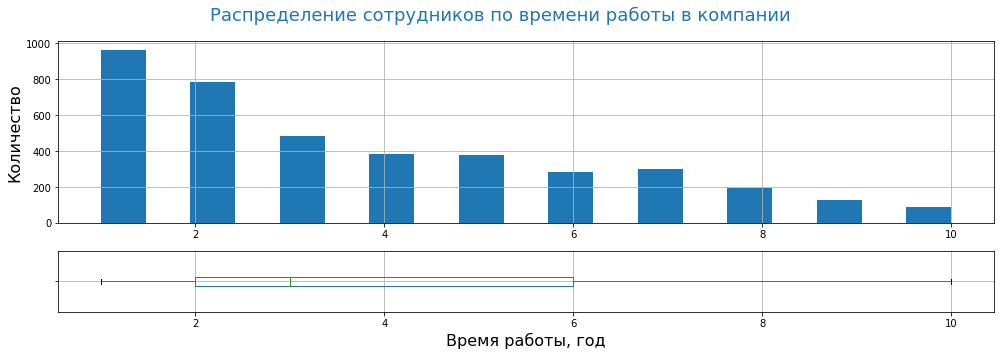

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
"Время работы, год",4000.0,3.7185,2.542513,1.0,2.0,3.0,6.0,10.0,Probably NOT,0.0


In [21]:
show_hist(
    train_job["employment_years"],
    "Распределение сотрудников по времени работы в компании", 
    "Время работы, год", bins=19,
    figsize=(14, 5), boxplot=True
)

Основная масса сотрудников работает в компании от 2-х до 6-ти лет, имеются сотрудники работающие 10 лет, но больше всего сотрудников работающих 1 год.

#### Категориальные признаки

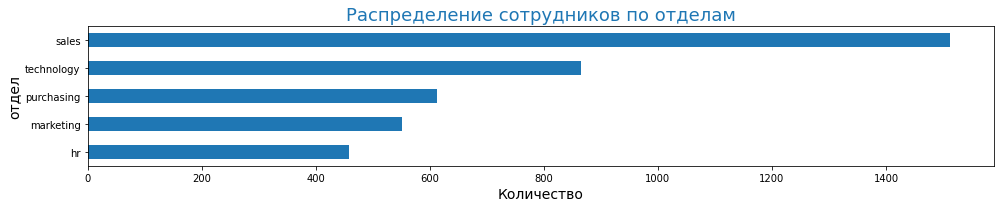

,sales,technology,purchasing,marketing,hr
Количество,37.8%,21.6%,15.3%,13.8%,11.5%


In [22]:
show_barh(
    train_job["dept"], "Распределение сотрудников по отделам", 
    "отдел", figsize=(14, 3)
)

Распределение по сотрудникам по мере уменьшения их количества следующее: `sales` (37.8%), `technology` (21.6%), `purchasing` (15.3%), `marketing` (13.8%), `hr` (11.5%).

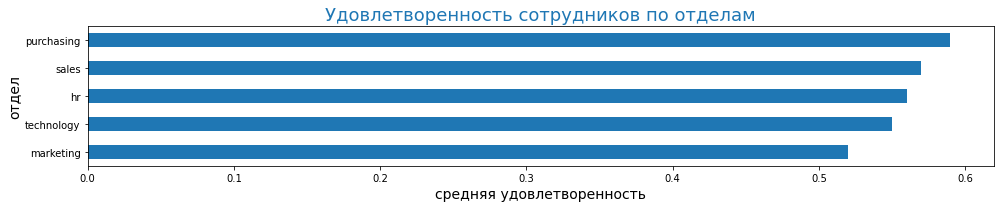

отдел,purchasing,sales,hr,technology,marketing
job_satisfaction_rate,0.59,0.57,0.56,0.55,0.52


In [23]:
show_barh(
    train_job.pivot_table(
        index="dept", values="job_satisfaction_rate", aggfunc="median"
    ), "Удовлетворенность сотрудников по отделам", "отдел", 
    xlabel="средняя удовлетворенность", figsize=(14, 3), percent=False
)

Cредний уровень удовлетворенности сотрудников по отделам распределяется по мере снижения следующим образом: `purchasing` (0.59), `sales` (0.57), `hr` (0.56), `technology` (0.55), `marketing` (0.52).

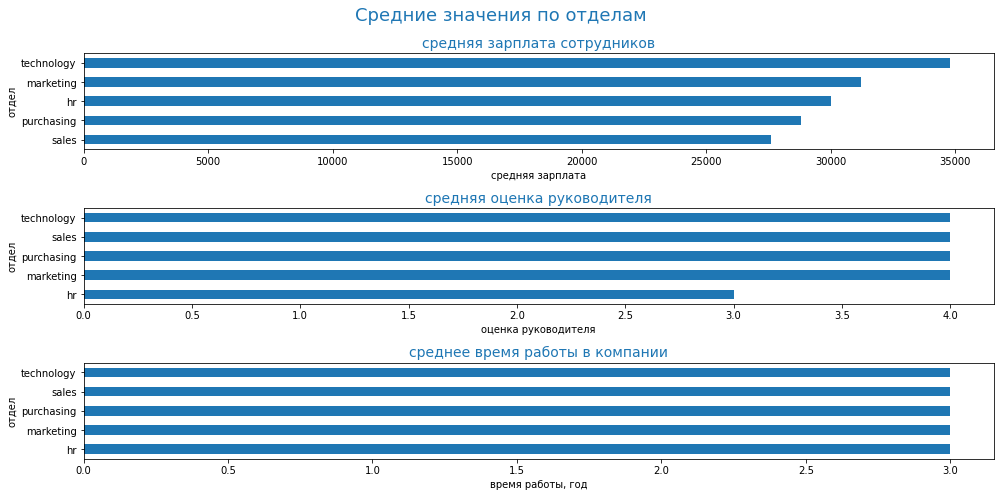

отдел,technology,marketing,hr,purchasing,sales
salary,34800,31200,30000,28800,27600
supervisor_evaluation,4,4,3,4,4
employment_years,3,3,3,3,3


In [24]:
# Словарь столбцов для перебора количественных признаков
quant_cols_desc = list(zip(
    quant_columns,
    [
        ["среднее время работы в компании","время работы, год"],
        ["средняя оценка руководителя", "оценка руководителя"],
        ["средняя зарплата сотрудников", "средняя зарплата"]
    ]
))

# Вывод графиков по остальным количественным признакам
fig= plt.figure()
cols_description = []
for i, (col, desc) in enumerate(quant_cols_desc[::-1]):
    dsc = show_barh(
        train_job.pivot_table(
            index="dept", values=col, aggfunc="median"
        ), 
        desc[0], "отдел", xlabel=desc[1], figsize=(14, 7), 
        ax=fig.add_subplot(3, 1, i+1), percent=False, show=False,
        large_text=False
    )
    cols_description.append(dsc)
plt.suptitle("Средние значения по отделам", size=18, color="C0")
plt.tight_layout()
plt.show()
display(pd.concat(cols_description))

Медианная заработная платы по отделам по мере снижения распределяется следующим образом: `technology` (27'600), `marketing` (28'800), `hr` (30'000), `purchasing` (31'200), `sales` (34'800).

Средняя оценка руководителем своих сотрудников по всем отделам равна 4, кроме отдела `hr` - скорее всего руководство не очень довольно работой сотрудников этого отдела или у него завышенные требования к сотрудникам.

Среднее время работы сотрудников в компании по отделам одинаковое - 3 года.

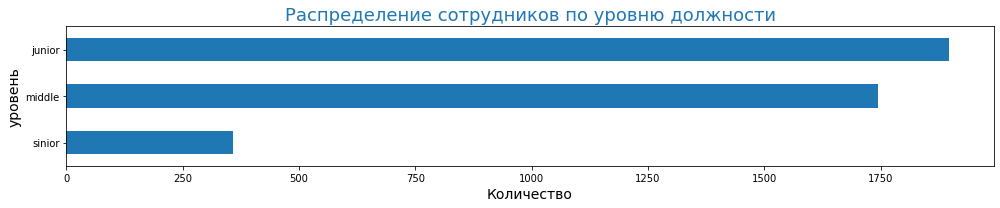

,junior,middle,sinior
Количество,47.4%,43.6%,8.9%


In [25]:
show_barh(
    train_job["level"], "Распределение сотрудников по уровню должности", 
    "уровень", figsize=(14, 3)
)

Распределение сотрудников должностям в компании следующее - `junior` (47.4%), `middle` (43.6%), `senior` (8.9%).

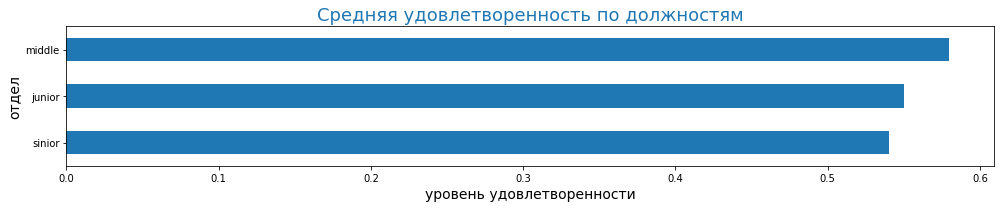

отдел,middle,junior,sinior
job_satisfaction_rate,0.58,0.55,0.54


In [26]:
show_barh(
    train_job.pivot_table(
        index="level", values="job_satisfaction_rate", aggfunc="median"
    ), 
    "Средняя удовлетворенность по должностям", "отдел", 
    xlabel="уровень удовлетворенности", figsize=(14, 3), percent=False
)

Распределение по уровню удовлетворенности сотрудников в зависимости от долности следующее: `middle` (0.58), `junior` (0.55), `senior` (0.54).

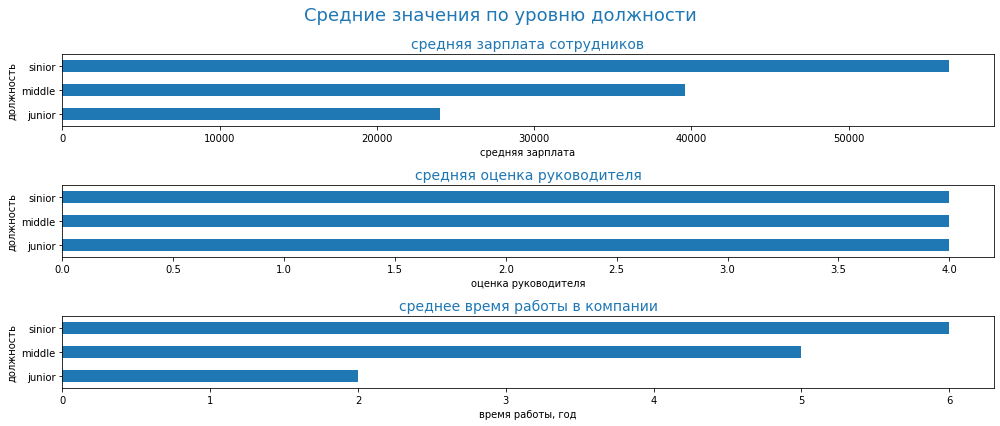

должность,sinior,middle,junior
salary,56400,39600,24000
supervisor_evaluation,4,4,4
employment_years,6,5,2


In [27]:
# Вывод графиков по остальным количественным признакам
fig= plt.figure()
cols_description = []
for i, (col, desc) in enumerate(quant_cols_desc[::-1]):
    dsc = show_barh(
        train_job.pivot_table(
            index="level", values=col, aggfunc="median"
        ), 
        desc[0], "должность", xlabel=desc[1], figsize=(14, 6), 
        ax=fig.add_subplot(3, 1, i+1), percent=False, show=False,
        large_text=False
    )
    cols_description.append(dsc)
plt.suptitle("Средние значения по уровню должности", size=18, color="C0")
plt.tight_layout()
plt.show()
display(pd.concat(cols_description))

Распределение средних заработных плат по должности предсказуемо распределяется следующим образом: `senior` (56'400), `middle` (39'600), `junior` (24'000)

Средняя оценка руководителя независимости от должности составляет 4 балла.

Среднее время работы в компании также довольно предсказуемо и составляет: `senior` (6 лет), `middle` (5 лет), `junior` (2 года)

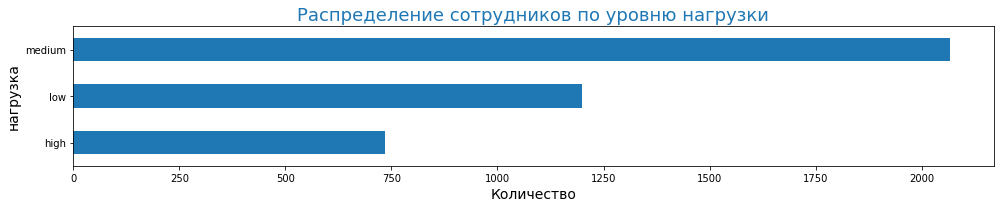

,medium,low,high
Количество,51.6%,30.0%,18.4%


In [28]:
show_barh(
    train_job["workload"], "Распределение сотрудников по уровню нагрузки", 
    "нагрузка", figsize=(14, 3)
)

У более половины 51.6% сотрудников нагрузка среднего уровня, низкий уровнь нагрузки у 30%, высокий - у 18.4%.

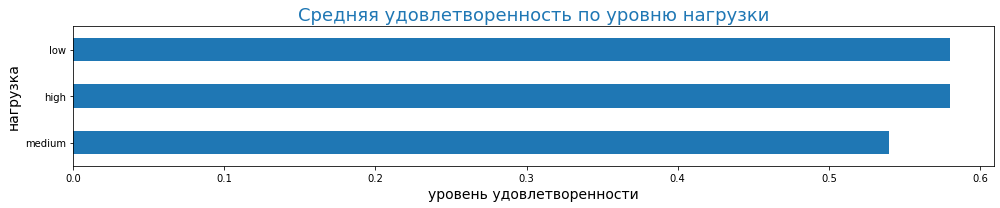

нагрузка,low,high,medium
job_satisfaction_rate,0.58,0.58,0.54


In [29]:
show_barh(
    train_job.pivot_table(
        index="workload", values="job_satisfaction_rate", aggfunc="median"
    ), 
    "Средняя удовлетворенность по уровню нагрузки", "нагрузка", 
    xlabel="уровень удовлетворенности", figsize=(14, 3), percent=False
)

Сотрудники со средним уровнем нагрузки в среднем показывают немного меньший уровень удовлетворенности работой в компании.

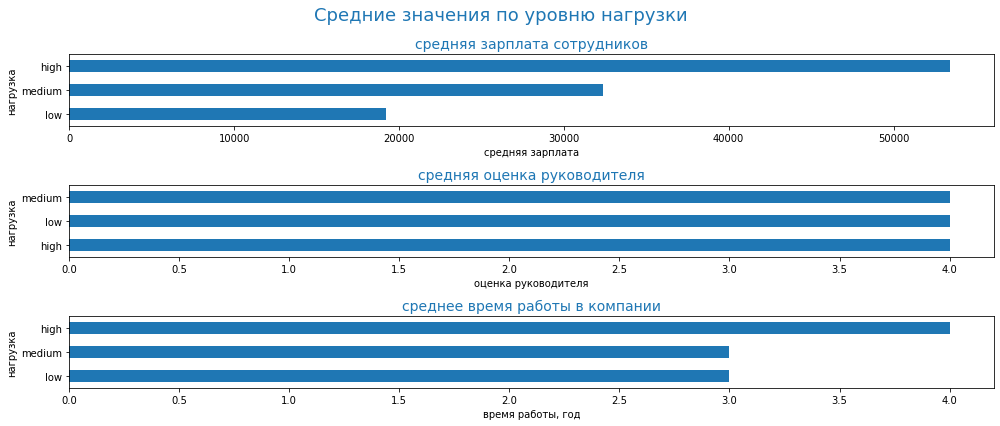

нагрузка,high,medium,low
salary,53400,32400,19200
supervisor_evaluation,4,4,4
employment_years,4,3,3


In [30]:
# Вывод графиков по остальным количественным признакам
fig= plt.figure()
cols_description = []
for i, (col, desc) in enumerate(quant_cols_desc[::-1]):
    dsc = show_barh(
        train_job.pivot_table(
            index="workload", values=col, aggfunc="median"
        ), 
        desc[0], "нагрузка", xlabel=desc[1], figsize=(14, 6), 
        ax=fig.add_subplot(3, 1, i+1), percent=False, show=False,
        large_text=False
    )
    cols_description.append(dsc)
plt.suptitle("Средние значения по уровню нагрузки", size=18, color="C0")
plt.tight_layout()
plt.show()
display(pd.concat(cols_description))

Средний уровень заработной платы имеет сильную зависимость от уровня нагрузки: `high` (53'400), `medium` (32'400), `low` (19'200).

Оценка руководителя одинаковая независимо от уровня нагрузки.

Среднее время работы у сотрудников с высоким уровнем нагрузки выше - 4 года против 3-х лет для других уровней.

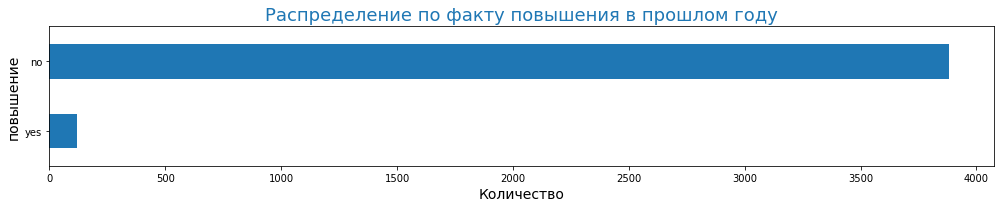

,no,yes
Количество,97.0%,3.0%


In [31]:
show_barh(
    train_job["last_year_promo"], "Распределение по факту повышения в прошлом году", 
    "повышение", figsize=(14, 3)
)

Повышение в прошлом году было всего у 3% работников из тренеровочной выборки.

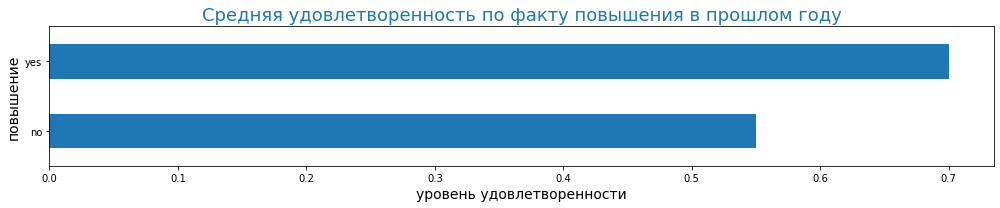

повышение,yes,no
job_satisfaction_rate,0.7,0.55


In [32]:
show_barh(
    train_job.pivot_table(
        index="last_year_promo", values="job_satisfaction_rate", aggfunc="median"
    ), 
    "Средняя удовлетворенность по факту повышения в прошлом году", "повышение", 
    xlabel="уровень удовлетворенности", figsize=(14, 3), percent=False
)

Средняя удовлетворенность работой в компании выше у сотрудников, которые добились повышения в прошлом году.

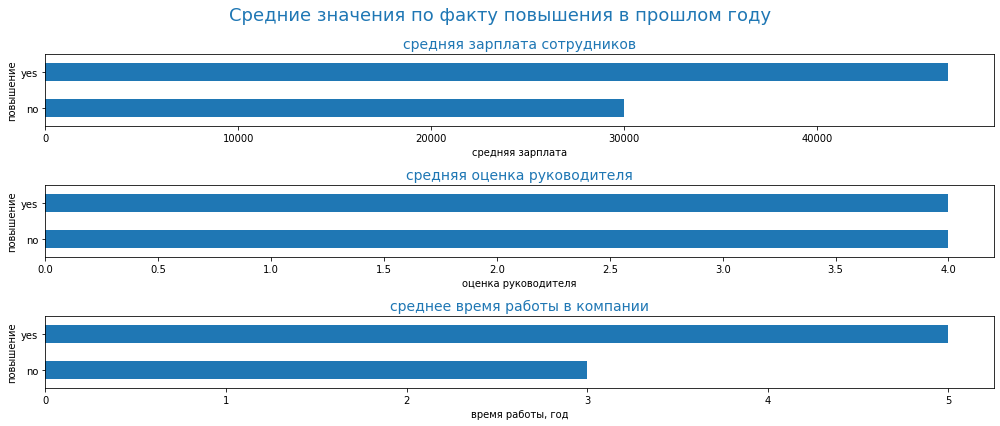

повышение,yes,no
salary,46800,30000
supervisor_evaluation,4,4
employment_years,5,3


In [33]:
# Вывод графиков по остальным количественным признакам
fig= plt.figure()
cols_description = []
for i, (col, desc) in enumerate(quant_cols_desc[::-1]):
    dsc = show_barh(
        train_job.pivot_table(
            index="last_year_promo", values=col, aggfunc="median"
        ), 
        desc[0], "повышение", xlabel=desc[1], figsize=(14, 6), 
        ax=fig.add_subplot(3, 1, i+1), percent=False, show=False,
        large_text=False
    )
    cols_description.append(dsc)
plt.suptitle("Средние значения по факту повышения в прошлом году", size=18, color="C0")
plt.tight_layout()
plt.show()
display(pd.concat(cols_description))

Сотрудники, у которых было повышение в прошлом году имеют более высокую среднюю зарплату - 46'800 против 30'000.

Средняя оценка руководителя не зависит от факта повышения в прошлом году.

Повышения достигли сотрудники, которые работают в компании в среднем больше остальных - 5 лет против 3-х.

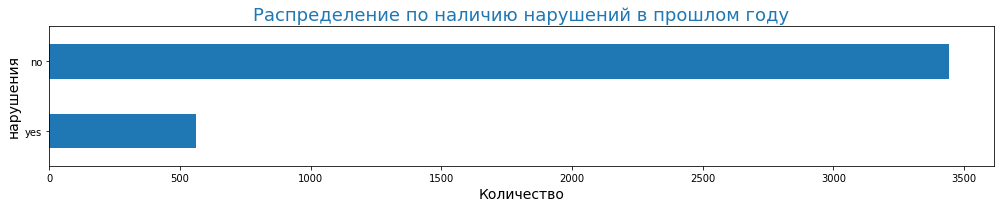

,no,yes
Количество,86.0%,14.0%


In [34]:
show_barh(
    train_job["last_year_violations"], "Распределение по наличию нарушений в прошлом году", 
    "нарушения", figsize=(14, 3)
)

Допустили нарушения в прошлом году 13% сотрудников.

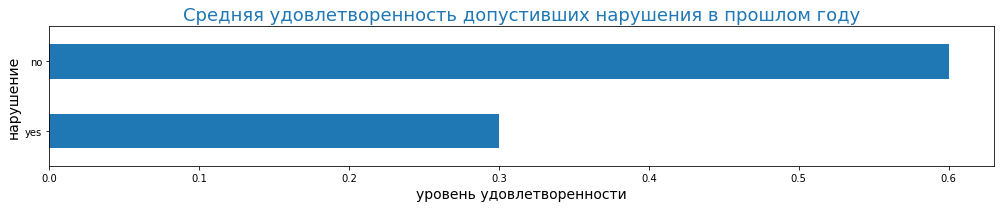

нарушение,no,yes
job_satisfaction_rate,0.6,0.3


In [35]:
show_barh(
    train_job.pivot_table(
        index="last_year_violations", values="job_satisfaction_rate", aggfunc="median"
    ), 
    "Средняя удовлетворенность допустивших нарушения в прошлом году", "нарушение", 
    xlabel="уровень удовлетворенности", figsize=(14, 3), percent=False
)

Средний уровень удовлетворенности работой в компании у сотрудников, допустивших нарушения в прошлом году значительно ниже остальных сотрудников - 0.3 против 0.6

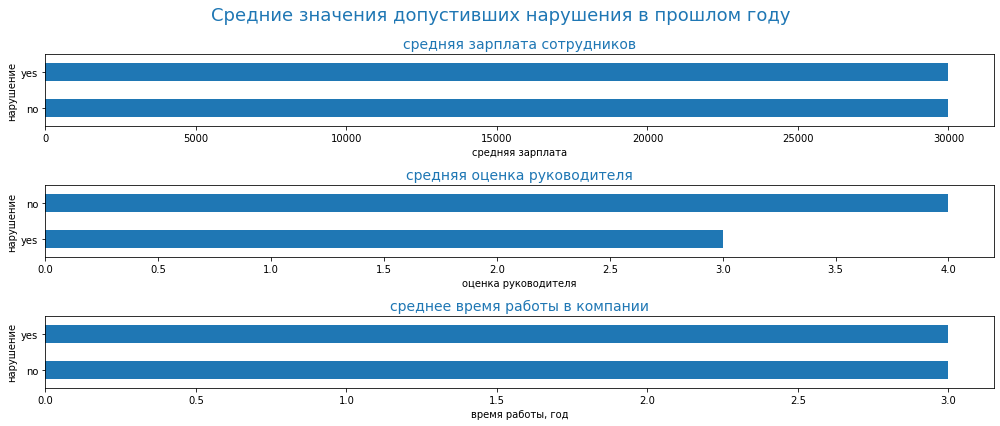

нарушение,yes,no
salary,30000,30000
supervisor_evaluation,3,4
employment_years,3,3


In [36]:
# Вывод графиков по остальным количественным признакам
fig= plt.figure()
cols_description = []
for i, (col, desc) in enumerate(quant_cols_desc[::-1]):
    dsc = show_barh(
        train_job.pivot_table(
            index="last_year_violations", values=col, aggfunc="median"
        ), 
        desc[0], "нарушение", xlabel=desc[1], figsize=(14, 6), 
        ax=fig.add_subplot(3, 1, i+1), percent=False, show=False,
        large_text=False
    )
    cols_description.append(dsc)
plt.suptitle("Средние значения допустивших нарушения в прошлом году", size=18, color="C0")
plt.tight_layout()
plt.show()
display(pd.concat(cols_description))

Средняя заработная плата в разрезе нарушений не имеет отклонений от средней по компании. Среднее время работы в компании также не значительно влияет на факт допущения нарушений.

От факта наличия нарушений зависит оценка руководителя, допустившие нарушения в среднем имеют 3 балла против 4-х у сотрудников, не допустивших нарушения в прошлом году.

#### Корреляционный анализ

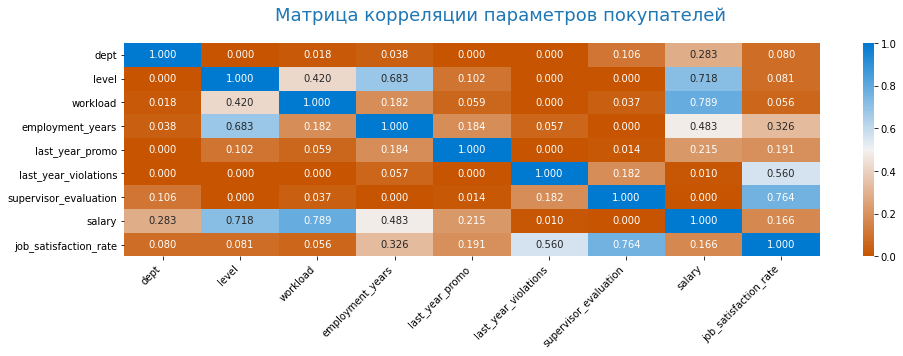

In [37]:
# Функция вывода матрицы коэффициентов корреляции Фи
def show_heatmap(
    data, title, interval_cols, figsize = (14, 14), 
    annot=True, fmt=".3f"
):
    plt.figure(figsize=figsize)
    sns.heatmap(
        (
            data.phik_matrix(interval_cols=interval_cols)
        ), 
        annot=annot, fmt=fmt,
        cmap=sns.diverging_palette(25, 250, s=100, l=50, as_cmap=True)
    )
    plt.suptitle(title, color="C0", size=18)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
show_heatmap(
    train_job, 
    "Матрица корреляции параметров покупателей",
    target_column_job + quant_columns, figsize = (14, 5)
)

Мультиколлинеарность отсутствует. По целевому признаку самая высокая корреляция наблюдается только с признаком оценки руководителя - 0.764. Также заметная корреляция имеется с признаком наличия нарушений за последний год - 0.560. Умеренная корреляция наблюдается с признаком времени работы в компании - 0.326.

Самая высокая корреляция в датасете между признаками зарплата и уровень нагрузки - 0.789, высокая корреляция зарплаты также с уровнем занимаемой должности - 0.718 и умеренная корреляция со временем работы в компании - 0.483.

По уровню занимаемой должности высокая корреляция со временем работы в компании - 0.683, а также умеренная корреляция с уровнем нагрузки сотрудника. По остальным признакам слабая корреляция.

In [38]:
# Функция вывода диаграммы рассеяния
def show_scatter(data: pd.DataFrame, x: str, y: str, title: str, xlabel: str, ylabel: str, 
                 by_columns: Optional[dict] = None, ncols: int = 2, ax = None,
                 figsize: tuple = (14, 20), alpha: float = 1, size: int = 3, noise=(0, 0)):
    data = data.copy()
    # Добавление дрожания для диаграммы рассеяния
    data[x] = data[x] + np.random.normal(0, noise[0], size=len(data))
    data[y] = data[y] + np.random.normal(0, noise[1], size=len(data))
    # если не указаны столбцы, то функция возвращает диаграмму по x и y
    if by_columns == None:
        ax = data.plot(kind="scatter", x=x, y=y, alpha=alpha, s=size, ax=ax)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        return ax
    # если столбцы указаны, то возвращает диаграммы по всем указанным столбцам
    # разделяя по цвету значения из этих столбцов
    elif isinstance(by_columns, dict):
        i = 0
        fig, axes = plt.subplots(len(by_columns)//ncols+1, ncols, figsize=figsize)
        if (np.prod(axes.shape) == ncols):
            one_dim = True
        else:
            one_dim = False
        data.plot(kind="scatter", x=x, y=y, alpha=alpha, s=size, 
                  ax=axes[i] if one_dim else axes[i//ncols, i%ncols],
                  xlabel=xlabel, ylabel=ylabel, title=f"{xlabel} - {ylabel}")
        for col, col_name in by_columns.items():
            i += 1
            col_values = list(data[col].unique())
            for val in col_values:
                data.query(f"{col} == '{val}'").plot(
                    kind="scatter", x=x, y=y, color="C" + str(col_values.index(val)), 
                    alpha=alpha, s=size, label=val,
                    ax=axes[i] if one_dim else axes[i//ncols, i%ncols], 
                    title=f"{xlabel} - {ylabel} ({col_name})", 
                    xlabel=xlabel, ylabel=ylabel
                )
            if one_dim:
                axes[i].legend(title=col_name)
            else:
                axes[i//ncols, i%ncols].legend(title=col_name)
        fig.suptitle(title+"\n", size=18, color="C0")
        fig.tight_layout()
        return fig

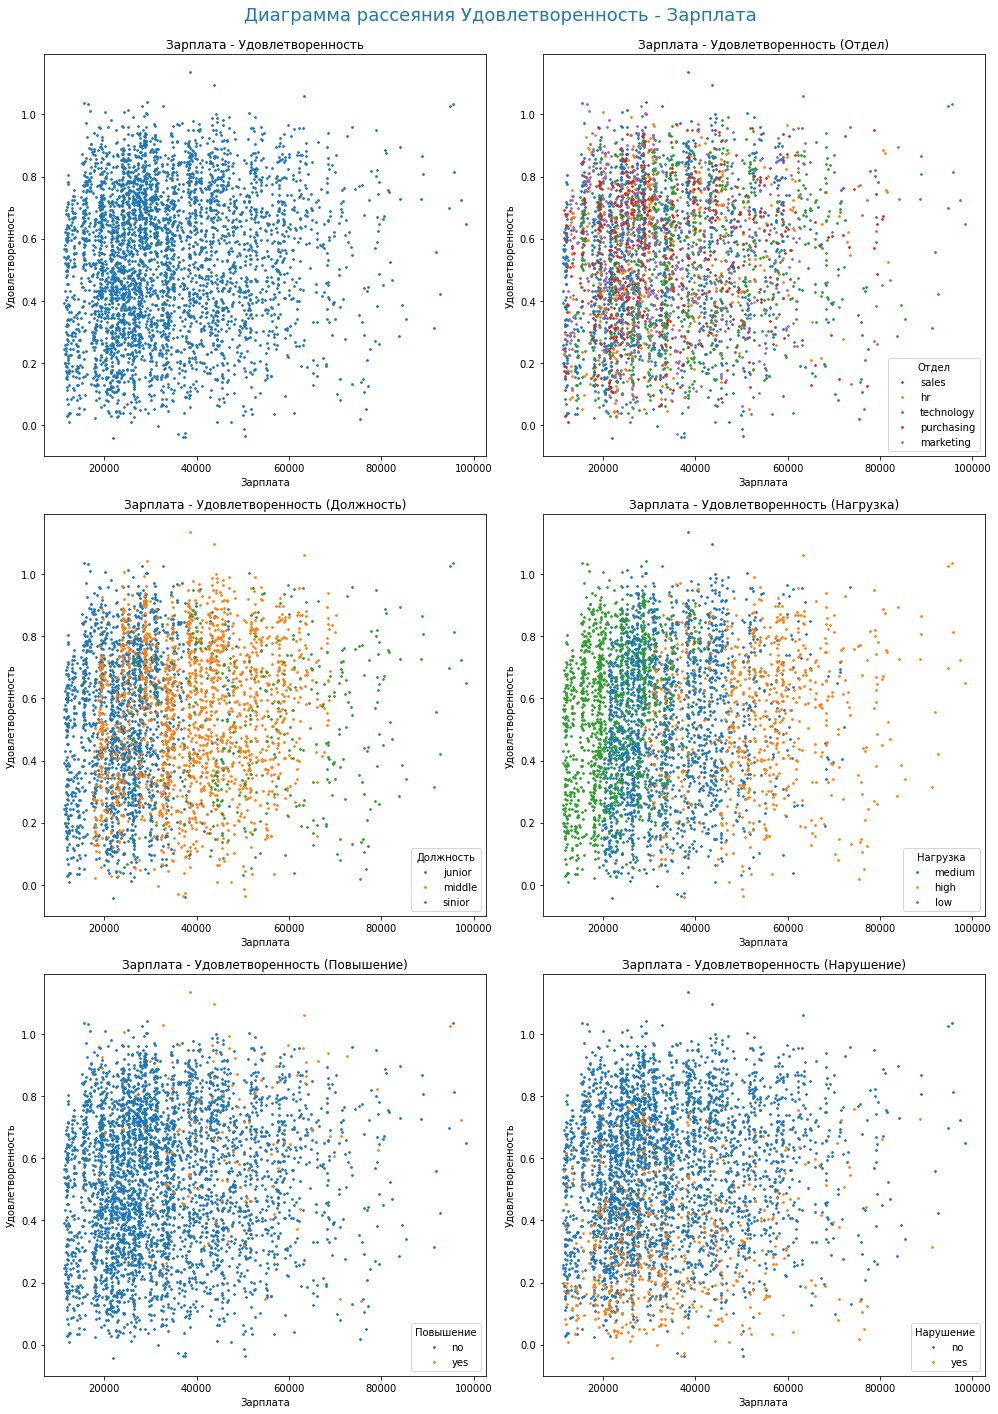

,employment_years,supervisor_evaluation,job_satisfaction_rate
Зарплата,0.47,0.00,0.13


In [39]:
# Словарь для описания категориальных признаков
qual_col_desc = dict(zip(
    qual_columns,
    ["Отдел", "Должность", "Нагрузка", "Повышение", "Нарушение"]
))

show_scatter(train_job, "salary", "job_satisfaction_rate", 
             "Диаграмма рассеяния Удовлетворенность - Зарплата", 
             "Зарплата", "Удовлетворенность", 
             qual_col_desc, noise=(300, 0.05))
plt.show()
(
    train_job[quant_columns + target_column_job].corr("spearman").loc["salary", :]
    .drop(["salary"]).rename("Зарплата")
    .to_frame().T.style.format("{:.2f}")
)

Диаграмма рассеяния между целевым признаком и заработной платой показывает низкую корреляцию. По графику заметно сильное влияние оказывают признаки наличия повышения и нарушений за последний год. Также заметно влияние на заработную плату оказывают уровень должности и нагрузки.

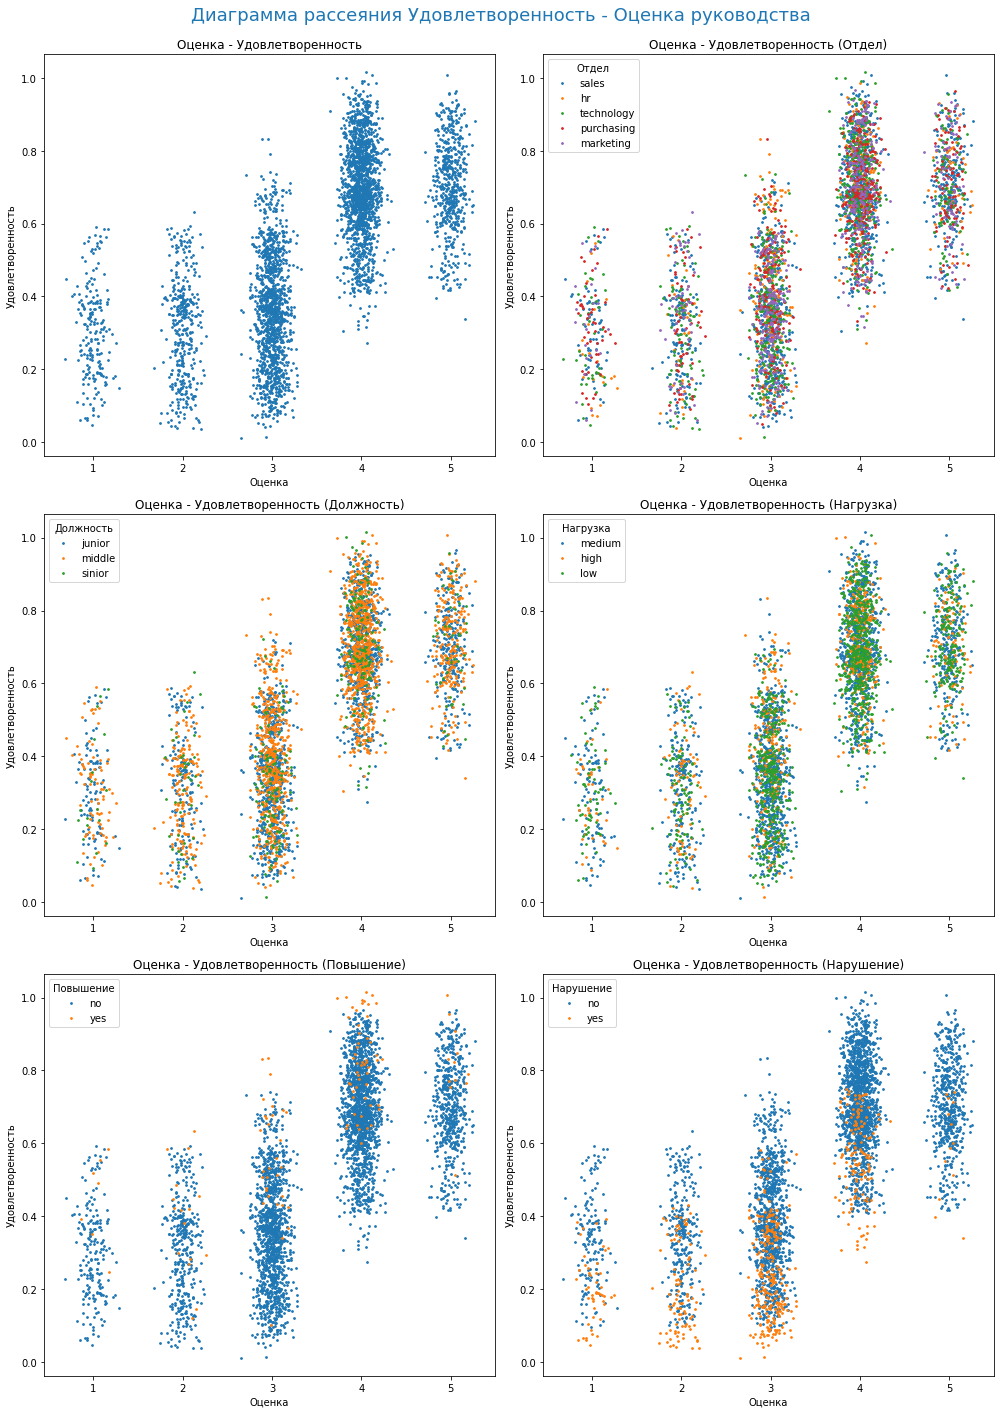

,employment_years,salary,job_satisfaction_rate
Зарплата,-0.00,0.00,0.75


In [40]:
show_scatter(train_job, "supervisor_evaluation", "job_satisfaction_rate", 
             "Диаграмма рассеяния Удовлетворенность - Оценка руководства", 
             "Оценка", "Удовлетворенность", 
             qual_col_desc, noise=(0.1, 0.01))
plt.show()
(
    train_job[quant_columns + target_column_job].corr("spearman").loc["supervisor_evaluation", :]
    .drop(["supervisor_evaluation"]).rename("Зарплата")
    .to_frame().T.style.format("{:.2f}")
)

По диаграмме рассеяния между целевым признаком и оценкой руководителя заметна корреляция - в целом заметен постепенный рост от оценки 1 до 4, причем между значениями 3 и 4 рост существенный. Между оценками 4 и 5 рост не сильно заметен, значения более сгруппированы. Можно было бы определить как две группы - до 3-х баллов включительно и выше 3-х баллов.

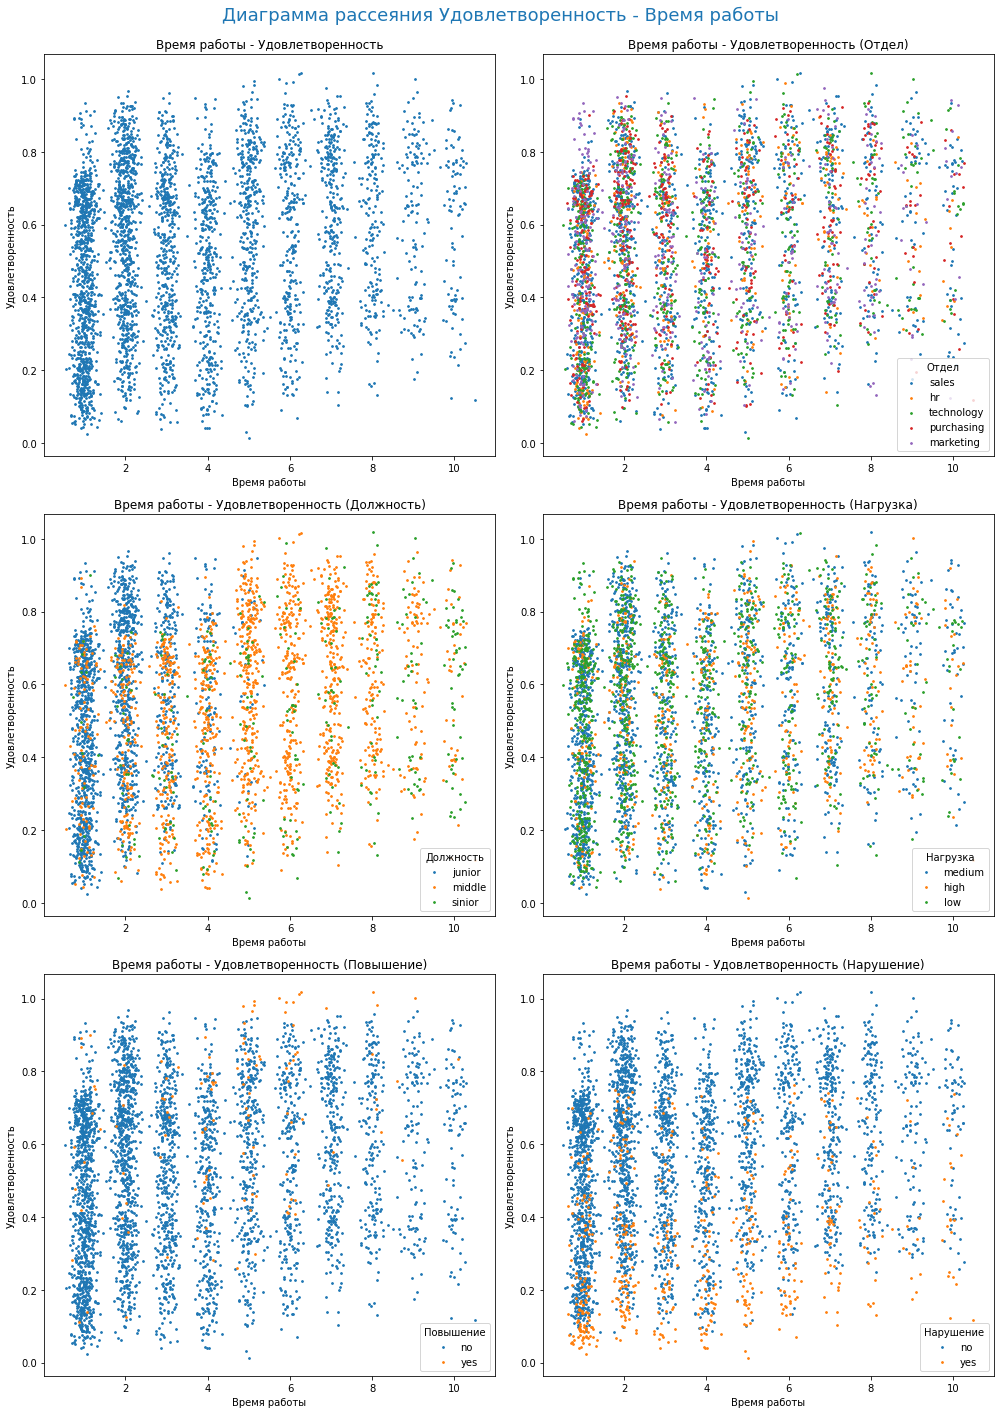

,employment_years,salary,job_satisfaction_rate
Зарплата,-0.00,0.00,0.75


In [41]:
show_scatter(train_job, "employment_years", "job_satisfaction_rate", 
             "Диаграмма рассеяния Удовлетворенность - Время работы", 
             "Время работы", "Удовлетворенность", 
             qual_col_desc, noise=(0.15, 0.01))
plt.show()
(
    train_job[quant_columns + target_column_job].corr("spearman").loc["supervisor_evaluation", :]
    .drop(["supervisor_evaluation"]).rename("Зарплата")
    .to_frame().T.style.format("{:.2f}")
)

По корреляции между целевым признаком и временем работы в компании также заметен небольшой постепенный рост удовлетворенности работников по мере увеличения времени работы. Также заметно влияние времени работы на уровень должности и нагрузки на сотрудников.

#### Промежуточные выводы

Проведен исследовательский и корреляционный анализ тренировочной выборки. По результатам анализа можно выделить следующее:
1. Целевым являет непрерывный количественный признак уровня удовлетворенности работой в компании, соответственно перед моделью стоит задача регрессии.
2. Имеются два бинарных признака, имеющие разнонаправленное влияние на целевой признак - повышение сотрудников за последний год и наличие у них нарушений в этот период.
3. Имеются порядковые признаки - уровень должности и рабочая нагрузка, которые лучше кодировать посредством OrdinalEncoder.
4. Мультиколлинеарность отсутствует, однако имеются признаки с достаточно высокой корреляцией - зарплата сильно коррелирует с уровенем нагрузки и уровнем занимаемой должности, целевой признак имеет высокую корреляцию с оценкой руководителя, а также заметная кореляция между признаками время работы в компании и уровень занимаемой должности.
5. Количество категориальных признаков достаточно большое, вероятно линейные модели будут не очень хороши для этой задачи, возможно более хорошим вариантом будет дерево решений.

### Подготовка данных

Проведем подготовку данных, кодирование департаментов будем производить посредством OneHotEncoder. Кодирование уровня должности и нагрузки сотрудников будем производить посредством OrdinalEncoder, так как это порядковые признаки. Кодирование бинарных признаков наличия повышения или нарушений в прошедшем году можно производить любым из вышеуказанных кодировщиков, в данном случае будет использоваться OrdinalEncoder. Заполнение пропущенных значений производится собственным преобразователем kNN_Imputer до препроцессора, но также добавил перед каждым пайплайном кодирования SimpleImputer на всякий случай.

In [42]:
# Пайплайн для OHE кодирования
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ("ohe", OneHotEncoder(
        drop="first", sparse_output=False, 
        categories=[job_categories[0]],
        handle_unknown="ignore"
    ))
])

# Пайплайн для ORD кодирования
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ("ord", OrdinalEncoder(
        categories=job_categories[1:]
    )),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
])

# Общий пайплайн для подготовки данных
data_prep_job = ColumnTransformer([
    ("ohe", ohe_pipe, [qual_columns[0]]),
    ("ord", ord_pipe, qual_columns[1:]),
    ("num", StandardScaler(), quant_columns)],
    remainder="passthrough"
)

Сформируем тренеровочную выборку. Так как дублированные значения не представляют ценности для модели, дубликаты будут исключены.

In [43]:
print(f"Размер исходного датасета: {train_job.shape}")
print(f"Количество явных дубликатов: {train_job.duplicated().sum()}\n")

X_train = train_job.drop_duplicates().drop("job_satisfaction_rate", axis=1)
y_train = train_job.drop_duplicates()["job_satisfaction_rate"]

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер целевого признака: {y_train.shape}")

Размер исходного датасета: (4000, 9)
Количество явных дубликатов: 248

Размер тренировочной выборки: (3752, 8)
Размер целевого признака: (3752,)


Тренеровочная выборка сформирована, после сокращения дубликатов количество уникальных комбинаций признаков сократилось до 3752.

#### Промежуточные выводы

Подготовлен пайплайн для подготовки данных:
1. Заполнение пропущенных значений посредством метода k ближайших соседей;
2. OHE кодирование категориального признака отдела `dept`;
3. Ordinal кодирование остальных категориальных признаков;
4. Масштабирование остальных некатегориальных признаков;
5. Модель машинного обучения для задачи регрессии.

Подготовлена тренировочная выборка для обучения моделей.

### Обучение моделей

Для предсказания целевого признака будут использованы модели по двум алгоритмам машинного обучения - линейная регрессия и дерево решений. В целях подбора гиперпараметров и поиска наиболее подходящей модели будет использован автоматизированный инструмент с кросс-валидацией на тренировочной выборке. 

В качестве метрики для поиска моделей будет использоваться SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»), которая показывает среднюю относительную ошибку предсказания модели в процентах. Критерий успеха - SMAPE ≤ 15 на тестовой выборке.

In [44]:
# Итоговый пайплайн - заполнение пропусков, кодирование, масштабирование и МО модель
final_pipe_job = Pipeline([
    ("imputer", imputer_pipe),
    ("preprocessor", data_prep_job),
    ("models", LinearRegression(n_jobs=-1))
])

# Функция для рассчета SMAPE
def smape_score(y_true, y_pred):
    if len(y_true) == len(y_pred):
        return np.sum(np.abs(y_true - y_pred) * 2 / (np.abs(y_true) + np.abs(y_pred))) * 100 / len(y_true)
    else:
        raise Exception("Lenght 'y_true' and 'y_pred' is not the same")

# Список моделей и их гиперпараметры для поиска лучшей модели
param_grid_job = [
    # словарь для модели LinearRegression()
    {
        "models": [LinearRegression(n_jobs=-1)],
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), RobustScaler(), "passthrough"]  
    },
    # словарь для модели DecisionTreeClassifier()
    {
        "models": [DecisionTreeRegressor(
            random_state=RANDOM_STATE
        )],
        "models__max_depth": range(15, 25),
        "models__min_samples_split": range(5, 10),
        "models__min_samples_leaf": range(1, 5),
        "preprocessor__num": ["passthrough"]
    }
]

# 
search_cv_job = RandomizedSearchCV(
    final_pipe_job, param_grid_job, 
    scoring=make_scorer(smape_score, greater_is_better=False),
    cv=5, n_jobs=-1, n_iter=20,
    random_state=RANDOM_STATE,
    error_score="raise"
)

start = time.time()

search_cv_job.fit(X_train, y_train)

print(f"Время поиска модели: {(time.time() - start):0.2f}\n")
print('Лучшая модель и её параметры:')
display(search_cv_job.best_estimator_)
print (f'Метрика лучшей модели после кросс-валидации:{(search_cv_job.best_score_ * -1):0.3f}')

Время поиска модели: 7.03

Лучшая модель и её параметры:


Pipeline(steps=[('imputer',
                 Pipeline(steps=[('imputer',
                                  KnnImputer(categories=[['sales', 'purchasing',
                                                          'hr', 'marketing',
                                                          'technology'],
                                                         ['junior', 'middle',
                                                          'sinior'],
                                                         ['low', 'medium',
                                                          'high'],
                                                         ['no', 'yes'],
                                                         ['no', 'yes']],
                                             string_cols=['dept', 'level',
                                                          'workload',
                                                          'last_year_promo',
                                                          'last_year_violations']))])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrou...
                                                                                               'high'],
                                                                                              ['no',
                                                                                               'yes'],
                                                                                              ['no',
                                                                                               'yes']])),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('num', 'passthrough',
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=24, min_samples_leaf=2,
                                       min_samples_split=7, random_state=42))])

Метрика лучшей модели после кросс-валидации:14.916


Лучшей моделью после кросс-валидации получилась модель дерева решений с максимальной глубиной 24, минимальным количеством листьев равным 2 и минимальным количеством выборок для разделения - 7. Оценим модель на тестовой выборке.

In [45]:
test_predict_job = search_cv_job.best_estimator_.predict(test_data)
print(
    "Метрика лучшей модели на тестовой выборке: ",
    np.abs(round(smape_score(
        test_target_job["job_satisfaction_rate"], 
        test_predict_job
    ), 3))
)

model_job = search_cv_job.best_estimator_

Метрика лучшей модели на тестовой выборке:  13.642


Метрика на тестовой выборке показывает даже более низкое среднее относительное отклонение ниже 14%. Дерево решений получается достаточно громоздким для визуального анализа. 

#### Промежуточные выводы

Произведен автоматизированный поиск наилучшей модели:
1. Выбраны две модели - линейная регрессия и дерево решений, в качестве метрики определено SMAPE (симметричное среднее абсолютное процентное отклонение)
2. Критерием успеха модели установлено значение SMAPE ≤ 15 на тестовой выборке, по результатам автоматизированно поиска модели наилучшей оказалась модель дерева решений с максимальной глубиной 24, минимальным количеством листьев равным 2 и минимальным количеством выборок для разделения - 7, значение SMAPE составляет 13.642.

Вероятно причиной лучшего результата модели дерева решений является наличие довольно большого количества категориальных признаков по отношению к количественным.

## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

In [46]:
train_quit = pd.read_csv("https://code.s3.yandex.net/datasets/train_quit.csv")
train_quit.info()
train_quit

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no


Признаки тестовой выборки из файла `train_quit.csv` для второй задачи аналогичны первой, изменения только в целевом признаке - `quit`. Общее количество записей - 4000, пропуски отсутствуют.

In [47]:
test_target_quit = pd.read_csv("https://code.s3.yandex.net/datasets/test_target_quit.csv")
test_target_quit.info()
test_target_quit

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
...,...,...
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no


Входные признаки те же, что и в предыдущем задании, необходимо проверить соответствие сотрудников по id в тестовой выборке и целевом признаке.

Общее количество записей 2000, пропуски также отсутствует.

#### Промежуточный вывод

Произведена загрузка данных по второй задаче:
1. Количество записей в тренировочной выборке - 4000, пропуски отсутствуют.
2. Тестовая выборка для второй задачи та же, что была для первой.
3. Целевой признак тестовой выборки содержит 2000 значений, пропуски отсутствуют.

### Предобработка данных

#### Тренировочные данные

In [48]:
show_duplicates(train_quit, qual_columns)

Количество явных дубликатов: 0

Уникальные значения по категориальным признакам
По признаку 'dept': ['sales' 'purchasing' 'marketing' 'technology' 'hr']
По признаку 'level': ['middle' 'junior' 'sinior']
По признаку 'workload': ['high' 'medium' 'low']
По признаку 'last_year_promo': ['no' 'yes']
По признаку 'last_year_violations': ['no' 'yes']


В отличие от первой выборки в данном датасете отсутствуют пропущенные значения. Однако сохраняется опечатка в значении уровня занимаемой должности - `sinior`. Проверим присутствуют ли в данном датасете пропущенные значения из предыдущего.

In [49]:
print(
    "Количество совпадений по id с пропущенными данными:",
    train_quit["id"].isin(job_missed_id[0]).sum()
)
train_quit = train_quit.set_index("id")

Количество совпадений по id с пропущенными данными: 0


Совпадения отсутствуют, вероятно это отдельная выборка. Оценим количественные признаки.

In [50]:
target_column_quit = ["quit"]

train_quit[quant_columns].describe(
    [0.0012, 0.01, 0.25, .5, 0.75, .99, .9988]
).T.drop(columns="count").style.format("{:,.2f}") \
.background_gradient(cmap=sns.diverging_palette(250, 25, s=100, l=50, as_cmap=True), axis=1)

,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
employment_years,3.70,2.54,1.00,1.00,1.00,2.00,3.00,6.00,10.00,10.00,10.00
supervisor_evaluation,3.47,1.00,1.00,1.00,1.00,3.00,4.00,4.00,5.00,5.00,5.00
salary,"33,805.80","15,152.42","12,000.00","12,000.00","12,000.00","22,800.00","30,000.00","43,200.00","79,200.00","92,882.88","96,000.00"


По количественным признакам аномальные отклонения отсутствуют.

#### Тестовые данные

In [51]:
show_duplicates(test_target_quit, target_column_quit)

Количество явных дубликатов: 0

Уникальные значения по категориальным признакам
По признаку 'quit': ['yes' 'no']


По целевому признаку явные дубликаты отсутствуют, некорректные значения тоже. Проверим соответствие по id сотрудников с датасетом признаков тестовой выборки.

In [52]:
test_target_quit = test_target_quit.sort_values(by="id").set_index("id")
print(
    "ID сотрудников в тестовой выборке полностью идентичны:",
    test_data.index.equals(test_target_quit.index)
)

ID сотрудников в тестовой выборке полностью идентичны: True


По тестовой выборке расхождения также не обнаружены.

#### Промежуточные выводы

Произведена загрузка тренировочной выборки и целевого признака тестовой выборки, остальные признаки тренировочной выборки загружены ранее.
1. Количество записей тренировочной выборки составляет 4000, пропуски отсутствуют. В датасете отсутствуют данные, которые имели пропуски в первой задче;
2. Количество записей тестовой выборки составляет 2000, датасет с основными признаками из первой задчи, пропуски имелись только в датасете первой задачи, по целевому признаку пропуски отсутствуют. Расхождений в данных не выявлено, все сотрудники имеются в датасете с целевым признаком.

### Исследовательский анализ данных

#### Категориальные признаки

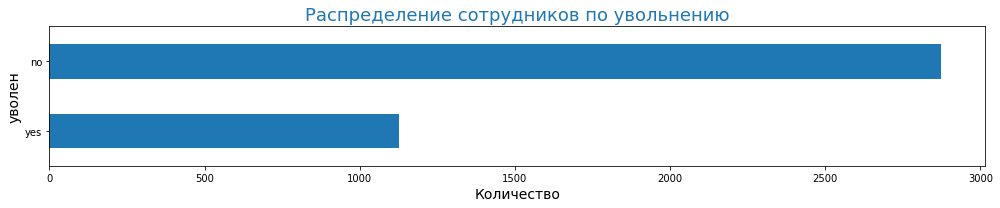

,no,yes
Количество,71.8%,28.2%


In [53]:
show_barh(
    train_quit["quit"], "Распределение сотрудников по увольнению", 
    "уволен", figsize=(14, 3)
)

В тренировочной выборке достаточно большое количество уволенных сотрудников - 28.2% из 4000. Целевой признак категориальный, при этом имеется дисбаланс данных.

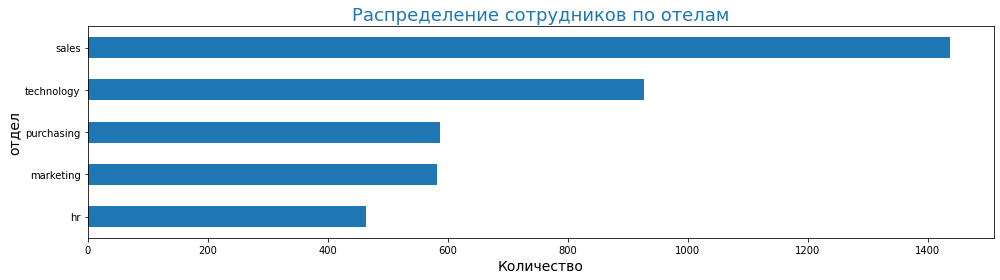

,sales,technology,purchasing,marketing,hr
Количество,35.9%,23.2%,14.7%,14.5%,11.6%


In [54]:
show_barh(
    train_quit["dept"], "Распределение сотрудников по отелам", 
    "отдел", figsize=(14, 4)
)

Распределение сотрудников по отделам близкое к распределению из первой задачи. Отделы по уменьшению сотрудников располагаются в следующем порядке - `sales`, `technology`, `purchasing`, `marketing`, `hr`.

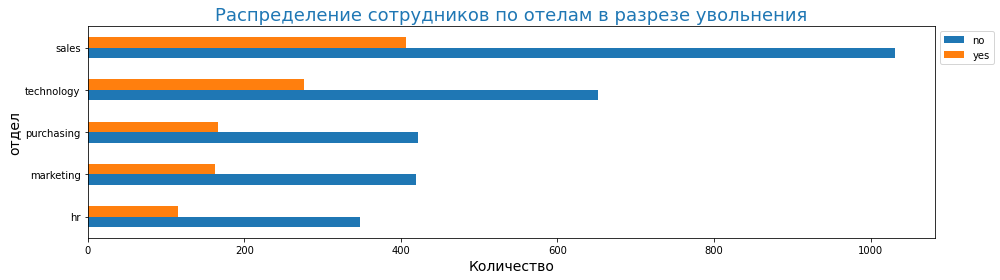

,no,yes
отдел,,
sales,71.7%,28.3%
technology,70.3%,29.7%
purchasing,71.8%,28.2%
marketing,72.0%,28.0%
hr,75.0%,25.0%


In [55]:
show_barh(
    train_quit.pivot_table(
        index="dept", columns="quit",
        values="salary", aggfunc="count"
    ),
    "Распределение сотрудников по отелам в разрезе увольнения", 
    "отдел", figsize=(14, 4)
)

По факту увольнения распределение сотрудников по отделам достаточно близкое от 25% до 29.7% от общего количества сотрудников. Наибольшее соотношение уволившихся сотрудников в отделе `technology`, однако по количеству сотрудников в отделах - наибольшее количество уволившихся сотрудников приходится на отдел `sales`.

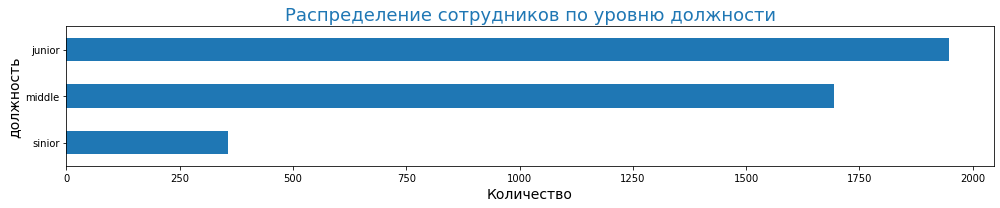

,junior,middle,sinior
Количество,48.7%,42.4%,8.9%


In [56]:
show_barh(
    train_quit["level"], "Распределение сотрудников по уровню должности", 
    "должность", figsize=(14, 3)
)

По уровню занимаемой должности распределение показывает достаточно низкое количество на уровне `senior` - 8.9%, другие уровни достаточно близки по распределению - 42.4% для `middle` и 48.7% для `junior`.

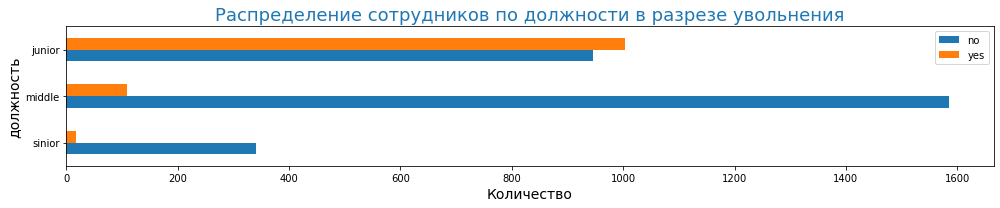

,no,yes
должность,,
junior,48.5%,51.5%
middle,93.6%,6.4%
sinior,95.2%,4.8%


In [57]:
show_barh(
    train_quit.pivot_table(
        index="level", columns="quit",
        values="salary", aggfunc="count"
    ),
    "Распределение сотрудников по должности в разрезе увольнения", 
    "должность", figsize=(14, 3)
)

По уровню должности заметно, что наибольшее число уволившихся сотрудников уровня `junior`, которых даже больше, чем не уволившихся - 51.5%. Для других должностей уволившихся значительно меньше - 6.4% для `middle` и 4.8% для `senior`.

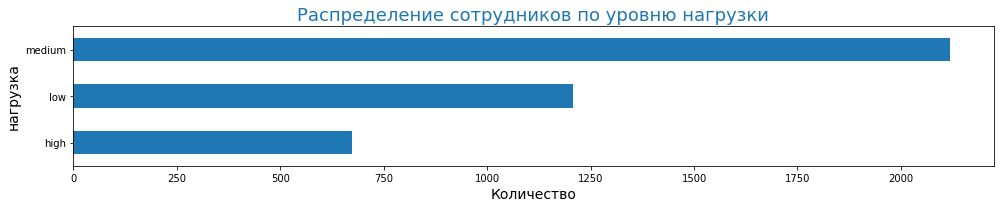

,medium,low,high
Количество,52.9%,30.2%,16.9%


In [58]:
show_barh(
    train_quit["workload"], "Распределение сотрудников по уровню нагрузки", 
    "нагрузка", figsize=(14, 3)
)

По уровню нагрузки наибольшее число сотрудников имеют среднюю нагрузку - 52.9%, низкую нагрузку имеют 30.2%, высокую - 16.9% по тренировочной выборке.

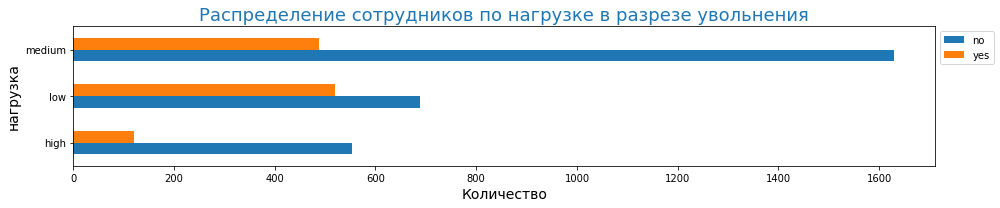

,no,yes
нагрузка,,
medium,77.0%,23.0%
low,57.0%,43.0%
high,82.0%,18.0%


In [59]:
show_barh(
    train_quit.pivot_table(
        index="workload", columns="quit",
        values="salary", aggfunc="count"
    ),
    "Распределение сотрудников по нагрузке в разрезе увольнения", 
    "нагрузка", figsize=(14, 3)
)

В разрезе уволившихся сотрудников наибольшее отношение уволенных имеют сотрудники с низким уровнем нагрузки - 43%, со средним уровнем отношение уволившихся 23%, с высоким - 18%.

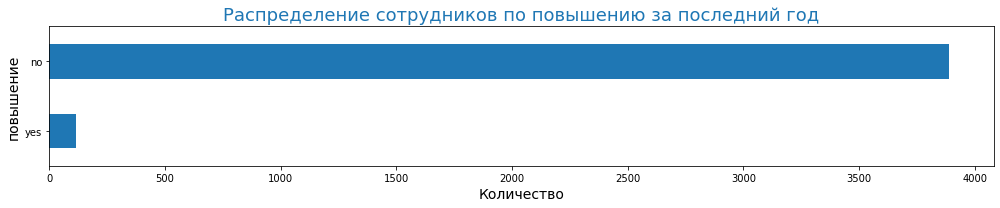

,no,yes
Количество,97.2%,2.8%


In [60]:
show_barh(
    train_quit["last_year_promo"], "Распределение сотрудников по повышению за последний год", 
    "повышение", figsize=(14, 3)
)

В тренировочной выборке повышение получили только 2.8% от всех сотрудников.

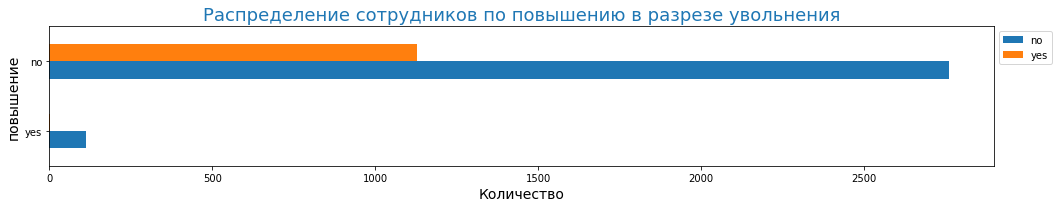

,no,yes
повышение,,
no,71.0%,29.0%
yes,99.1%,0.9%


In [61]:
show_barh(
    train_quit.pivot_table(
        index="last_year_promo", columns="quit",
        values="salary", aggfunc="count"
    ),
    "Распределение сотрудников по повышению в разрезе увольнения", 
    "повышение", figsize=(14, 3)
)

Отношение уволившихся сотрудников, получивших повышение в прошлом году очень низкое - 0.9%, по неполучившим 29% уволились.

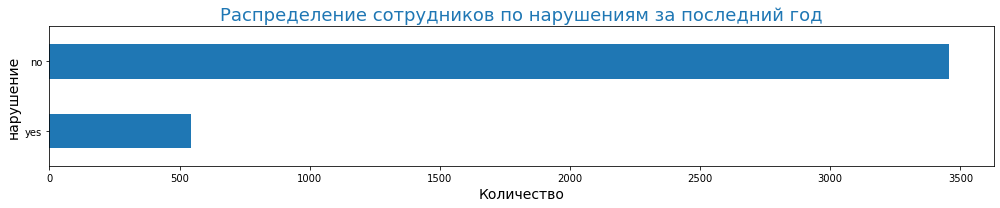

,no,yes
Количество,86.4%,13.6%


In [62]:
show_barh(
    train_quit["last_year_violations"], "Распределение сотрудников по нарушениям за последний год", 
    "нарушение", figsize=(14, 3)
)

По количеству нарушений в последний год 13.6% сотрудников допускали нарушение.

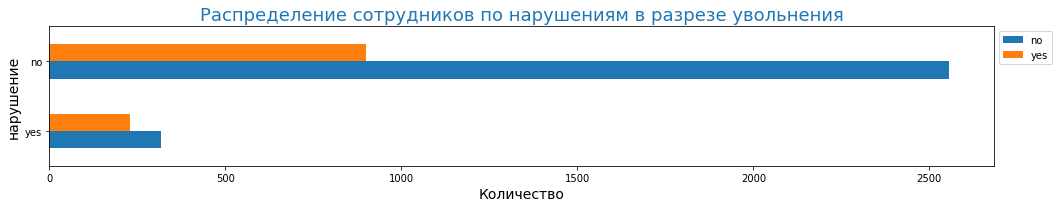

,no,yes
нарушение,,
no,74.0%,26.0%
yes,58.2%,41.8%


In [63]:
show_barh(
    train_quit.pivot_table(
        index="last_year_violations", columns="quit",
        values="salary", aggfunc="count"
    ),
    "Распределение сотрудников по нарушениям в разрезе увольнения", 
    "нарушение", figsize=(14, 3)
)

Соотноошение уволенных сотрудников среди тех, которые допустили нарушение за последний год достаточно высокое - 41.8%, для недопустивших нарушение соотношение значительно ниже - 26%.

#### Количественные признаки

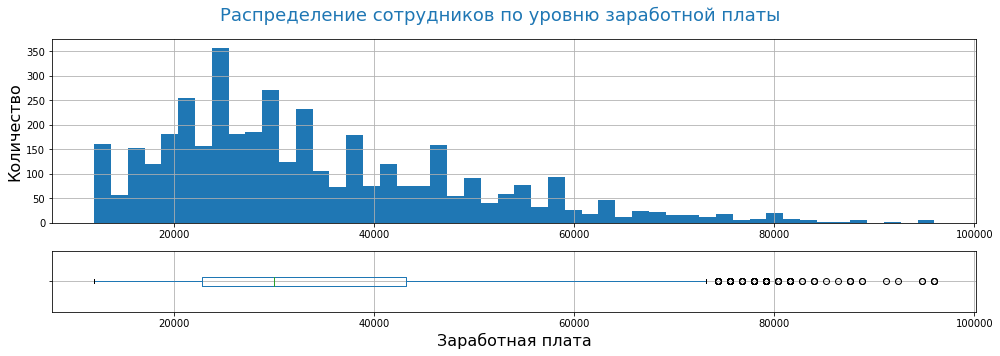

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Заработная плата,4000.0,33805.8,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0,Probably NOT,1.089006e-39


In [64]:
show_hist(
    train_quit["salary"],
    "Распределение сотрудников по уровню заработной платы", 
    "Заработная плата",
    figsize=(14, 5), boxplot=True
)

Распределение заработной платы имеет правое отклонение, половина сотрудников получает заработную плату в пределах 22'800-43'200, самая низка зарплата 12'000, самая высокая - 96'000.

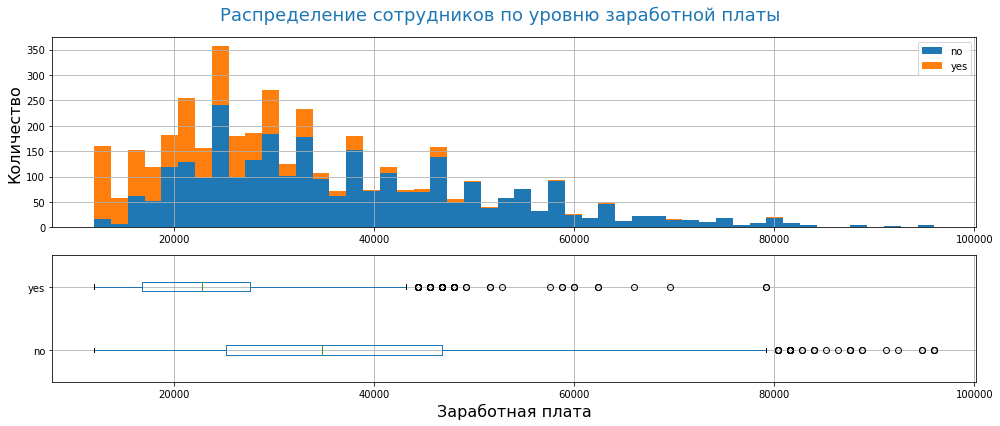

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Уволен,,,,,,,,,,
yes,1128.0,23885.106383,9351.599505,12000.0,16800.0,22800.0,27600.0,79200.0,Probably NOT,5.031293e-26
no,2872.0,37702.228412,15218.977339,12000.0,25200.0,34800.0,46800.0,96000.0,Probably NOT,1.288444e-31


In [65]:
show_hist(
    train_quit.pivot(
        columns="quit", values="salary"
    ),
    "Распределение сотрудников по уровню заработной платы",
    "Заработная плата", columns="Уволен"
)

В разрезе уволившихся сотрудников заметен сдвиг влево к более низким значениям заработной платы, половина таких сотрудников имеют зарплату в пределах 16'800-27'600.

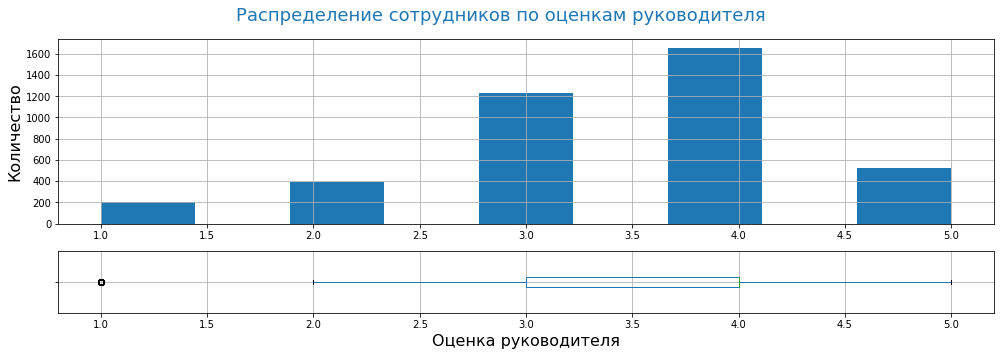

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Оценка руководителя,4000.0,3.47475,1.004049,1.0,3.0,4.0,4.0,5.0,Probably NOT,0.0


In [66]:
show_hist(
    train_quit["supervisor_evaluation"],
    "Распределение сотрудников по оценкам руководителя", 
    "Оценка руководителя", bins=9,
    figsize=(14, 5), boxplot=True
)

Основная масса оценок приходится на 3-4 балла. Самая часто встречающаяся оценка - 4.

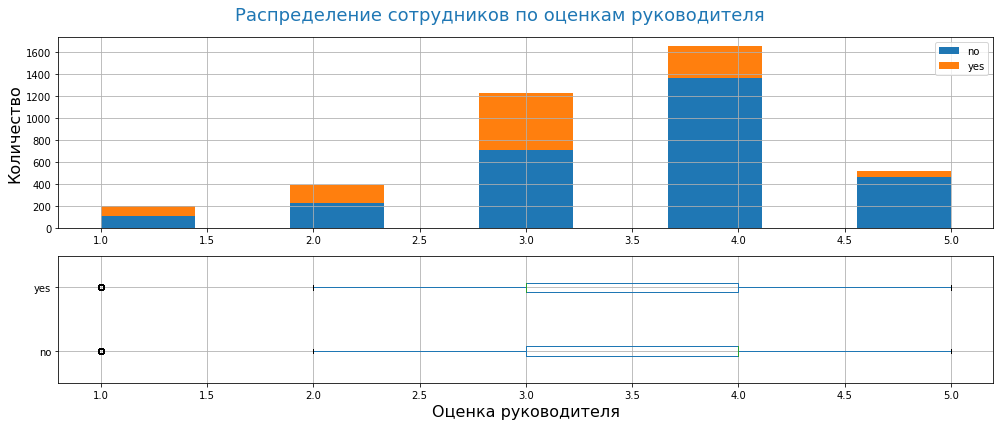

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Уволен,,,,,,,,,,
yes,1128.0,3.046099,0.973291,1.0,3.0,3.0,4.0,5.0,Probably NOT,1.057987e-27
no,2872.0,3.643106,0.965295,1.0,3.0,4.0,4.0,5.0,Probably NOT,8.407791e-45


In [67]:
show_hist(
    train_quit.pivot(
        columns="quit", values="supervisor_evaluation"
    ),
    "Распределение сотрудников по оценкам руководителя",
    "Оценка руководителя", columns="Уволен", bins=9
)

По графику заметно, что более высокое соотношение уволенных сотрудников приходится на более низкие оценки руководителя.

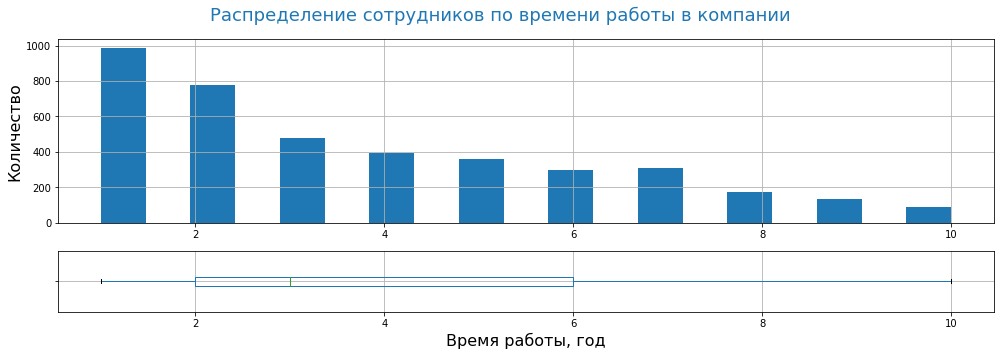

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
"Время работы, год",4000.0,3.7015,2.541852,1.0,2.0,3.0,6.0,10.0,Probably NOT,0.0


In [68]:
show_hist(
    train_quit["employment_years"],
    "Распределение сотрудников по времени работы в компании", 
    "Время работы, год", bins=19,
    figsize=(14, 5), boxplot=True
)

По времени работы половина сотрудников работает от 2-х до 6-ти лет. Больше всего сотрудников работающих 1 год, также имеются старожилы работающие до 10 лет в компании.

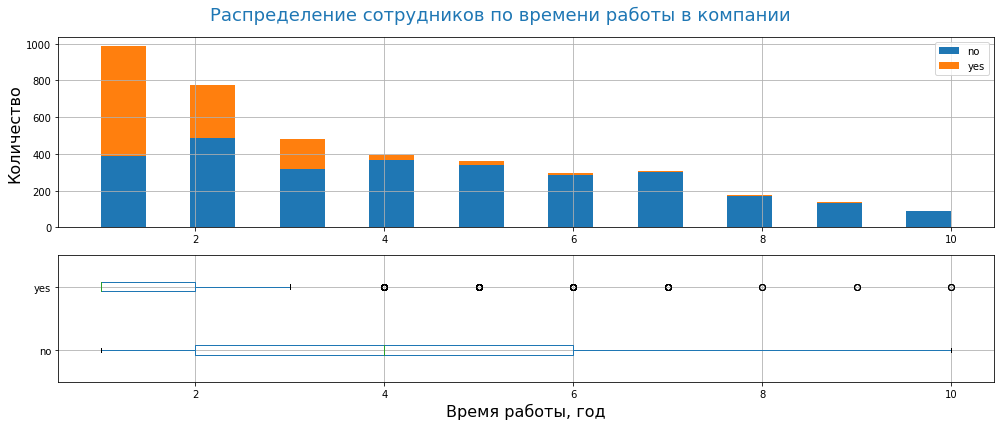

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Уволен,,,,,,,,,,
yes,1128.0,1.844858,1.274920,1.0,1.0,1.0,2.0,10.0,Probably NOT,5.310921e-42
no,2872.0,4.430710,2.544635,1.0,2.0,4.0,6.0,10.0,Probably NOT,1.832359e-33


In [69]:
show_hist(
    train_quit.pivot(
        columns="quit", values="employment_years"
    ),
    "Распределение сотрудников по времени работы в компании",
    "Время работы, год", columns="Уволен", bins=19
)

По времени работы наибольшее число уволившихся сотрудников приходится на первый год, половина уволившихся сотрудников приходится на первые 2 года, хотя имеются сотрудники, уволившиеся на 10-м году работы в компании.

#### Корреляционный анализ

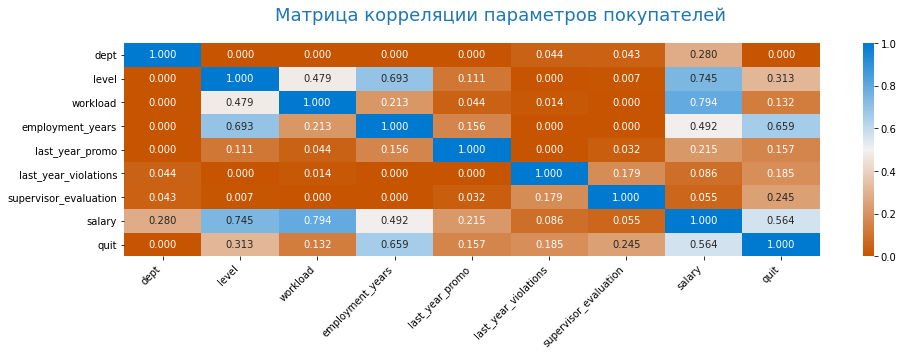

In [70]:
show_heatmap(
    train_quit, 
    "Матрица корреляции параметров покупателей",
    quant_columns, figsize = (14, 5)
)

Мультиколлинеарность отсутствует. По целевому признаку высокая корреляция с другими не наблюдается, имеется заметная корреляция с временем работы в компании - 0.659, а также с уровнем заработной платы - 0.564. Умеренная корреляция имеется также с уровнем должности сотрудника - 0.313.

По уровню заработной платы имеется высокая корреляция с признаками уровня нагрузки - 0.794 и должности - 0.745. Также умеренная корреляция с временем работы в компании - 0.492. Также заметная корреляция уровня занимаемой должности с временем работы в компании - 0.693 и умеренная корреляция с уровнем нагрузки - 0.479.

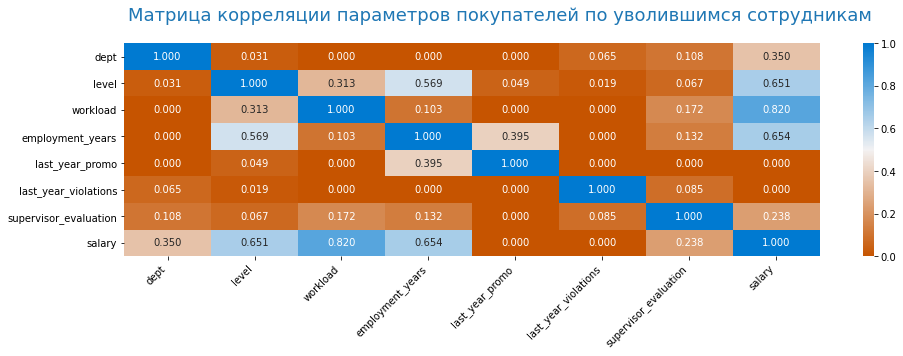

In [71]:
show_heatmap(
    train_quit.query("quit == 'yes'").drop(["quit"], axis=1), 
    "Матрица корреляции параметров покупателей по уволившимся сотрудникам",
    quant_columns, figsize = (14, 5)
)

По уволившимся сотрудникам заметно более высокая корреляция заработной платы с признаками рабочей нагрузки - 0.82 и временем работы - 0.654, корреляция с уровнем должности снизилась до 0.651. Также увеличилась корреляция между временем работы и повышением за последний год до 0.395. Заметно снизилась корреляция уровня занимаемой должности с признаками нагрузки и временем работы.

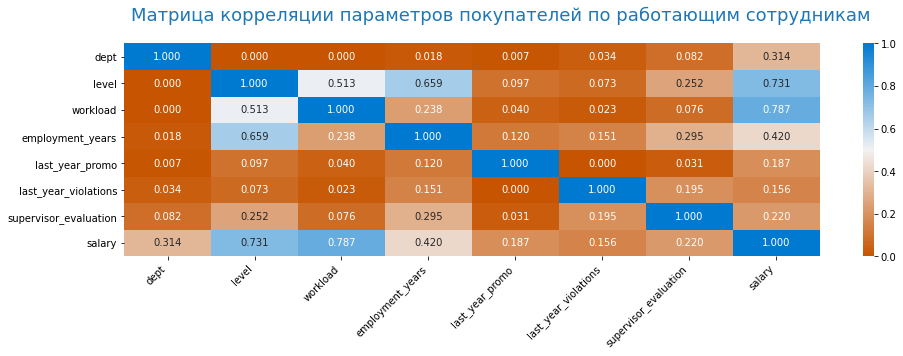

In [72]:
show_heatmap(
    train_quit.query("quit == 'no'").drop(["quit"], axis=1), 
    "Матрица корреляции параметров покупателей по работающим сотрудникам",
    quant_columns, figsize = (14, 5)
)

По сотрудникам, которые остались работать в компании также заметен рост корреляции уровня занимаемой должности с уровнем нагрузки и временем работы в компании. Корреляция по другим признакам изменилась не столь заметно, наблюдается несущественное снижение корреляции уровня зарплаты с другими признаками.

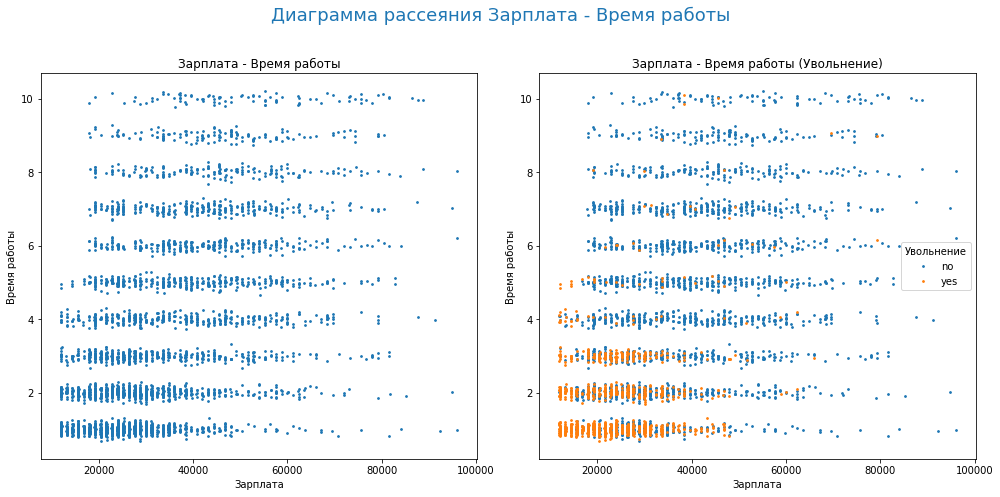

,employment_years,supervisor_evaluation
Зарплата,0.47,0.00


In [73]:
show_scatter(train_quit, "salary", "employment_years", 
             "Диаграмма рассеяния Зарплата - Время работы", 
             "Зарплата", "Время работы", {"quit": "Увольнение"}, 
             figsize=(14, 7), noise=(50, 0.1))
plt.show()
(
    train_job[quant_columns].corr("spearman").loc["salary", :]
    .drop(["salary"]).rename("Зарплата")
    .to_frame().T.style.format("{:.2f}")
)

Уволившиеся сотрудники в основном имеют более низкую зарплату и увольняются из компании в течение ближайших 2-3 лет.

#### Влияние уровня удовлетворенности

HR-налитики считают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Необходимо проверить данное утверждение.

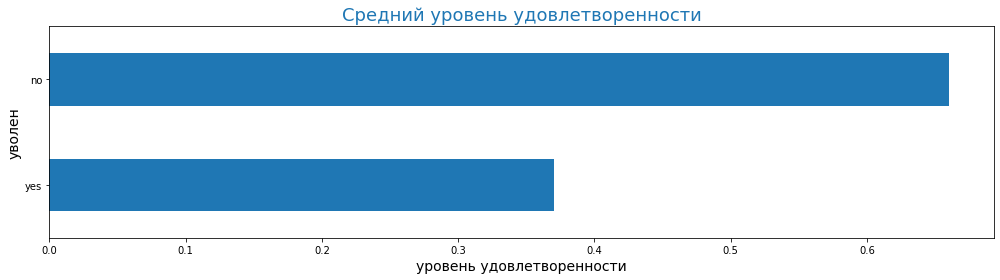

quit,no,yes
job_satisfaction_rate,0.66,0.37


In [74]:
show_barh(
    test_target_job.join(test_target_quit).pivot_table(
        index="quit", values="job_satisfaction_rate", 
        aggfunc="median"
    ).sort_values(by="job_satisfaction_rate", ascending=True), 
    "Средний уровень удовлетворенности", "уволен", 
    xlabel="уровень удовлетворенности", percent=False,
    figsize=(14, 4), counts=False
)

Средний уровень удовлетворенности уволенных сотрудников значительно ниже оставшихся работать и составляет 0.37 против 0.66. Оценим распределение уволенных по уровню удовлетворенности.

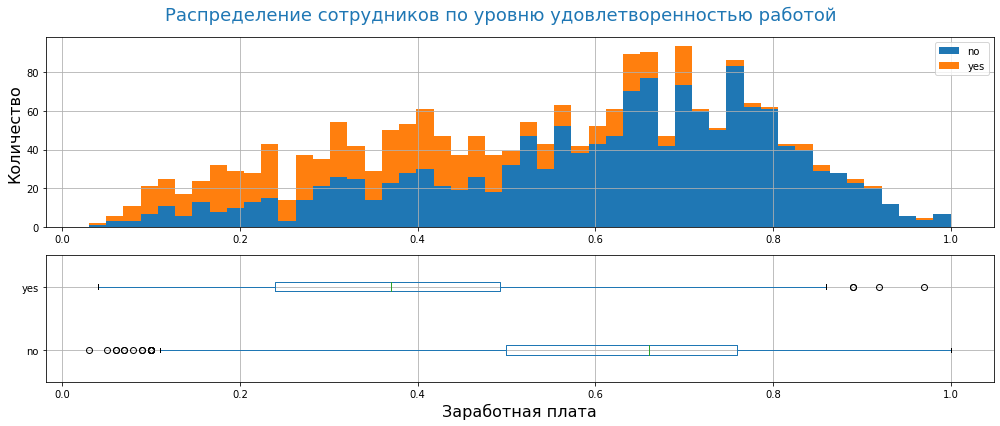

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Уволен,,,,,,,,,,
yes,564.0,0.387713,0.185784,0.04,0.24,0.37,0.4925,0.97,Probably NOT,5.042376e-08
no,1436.0,0.612040,0.199367,0.03,0.50,0.66,0.7600,1.00,Probably NOT,7.273844e-20


Коэффициент корреляции: -0.457


In [75]:
show_hist(
    test_target_job.join(test_target_quit).pivot(
        columns="quit", values="job_satisfaction_rate"
    ),
    "Распределение сотрудников по уровню удовлетворенностью работой",
    "Заработная плата", columns="Уволен"
)
print(
    "Коэффициент корреляции:",
    round(
        test_target_job.join(
            test_target_quit["quit"] == "yes"
        ).corr("spearman")["quit"][0], 3
    )
)

Распределение сотрудников по уровню удовлетворенности работой также показывает заметно более высокое соотношение уволенных сотрудников с низким уровнем удовлетворенности. Половина уволившихся сотрудников имели уровень удовлетворенности работой от 0.24 до 0.49, в то время как не уволившиеся от 0.5 до 0.76. Коэффициент корреляции -0.457, что говорит об умеренной обратной корреляции.

#### Промежуточные выводы

Проведен исследовательский анализ тренировочной выборки, по результатам которого можно определить портрет типового уволившегося сотрудника: 
1. сотрудник уровня `junior` из отдела `sales` или `technology`, имеющий низкий или реже средний уровень нагрузки;
2. сотрудник с более низким уровне заработной платы, среднее значение которой составляет 22'800 против 34'800 для неуволившихся сотрудников.
3. сотрудник работает в компании около 1-2 лет, не имеет повышений за последний год и вероятнее всего допустил нарушение трудового договора.
4. средняя оценка руководителя качества работы такого сотрудника около 3-х в отличие от неуволившихся сотрудников, оценка которых в среднем составляет 4 балла.

Также проведено исследование зависимости факта увольнения сотрудника от уровня удовлетворености работой в компании. Средняя удовлетворенность работой в компании уволенного сотрудника более низкая - 0.37 в отличие от остальных работников, средний уровень удовлетворенности которых составляет 0.66. Половина уволившихся сотрудников имела уровнь удовлетворенности от 0.24 до 0.49, тогда как у остальных сотрудников этот промежуток составляет от 0.5 до 0.76. Это говорит о том, что уровень удовлетворенности может оказывать достаточное влияние на фактор увольнения сотрудника.

### Добавление нового входного признака

В виду того, что уровень удовлетворенности сотрудников может оказывать достаточное влияние на фактор увольнения сотрудника добавим результаты моделирования лучшей модели из первой задачи в тренировочную и тестовую выборки.

In [76]:
# Тренировочная выборка
train_quit["job_satisfaction_rate"] = model_job.predict(train_quit.drop("quit", axis=1))
print("Тренировочная выборка:")
display(train_quit.head(5))

# Тестовая выборка
X_test = test_data.join(pd.DataFrame(
    {"job_satisfaction_rate": model_job.predict(test_data)},
    index = test_data.index
))
print("Тестовая выборка:")
display(X_test.head(5))

Тренировочная выборка:


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.605000
814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.413333
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.350000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.796667


Тестовая выборка:


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.850
100480,marketing,junior,low,4,no,no,4,16800,0.852
100503,purchasing,middle,high,5,no,no,4,55200,0.814
100610,sales,middle,medium,5,no,no,4,43200,0.814
100692,sales,middle,high,6,no,no,4,48000,0.696


#### Промежуточные выводы

В тренировочную и тестовую выборки добавлены результаты предсказания лучшей модели уровня удовлетворенности сотрудника работой в компании.

### Подготовка данных

Для подготовки данных воспользуемся пайплайнами из первой задачи. Требуется только изменить список признаков для масштабирования с учетом добавления признака уровня удовлетворенности сотрудника работой в компании. 

Также подготовим данные для обучения модели, для снижения избыточности данных удалим все дубликаты в тренировочной выборке.

In [77]:
# Общий пайплайн для подготовки данных
data_prep_quit = ColumnTransformer([
    ("ohe", ohe_pipe, [qual_columns[0]]),
    ("ord", ord_pipe, qual_columns[1:]),
    ("num", StandardScaler(), quant_columns + target_column_job)],
    remainder="passthrough"
)

# Подготовка тренировочной выборки и разделение целевого признака
print(f"Размер исходного датасета: {train_quit.shape}")
print(f"Количество явных дубликатов: {train_quit.duplicated().sum()}\n")

X_train = train_quit.drop_duplicates().drop("quit", axis=1)
y_train = train_quit.drop_duplicates()["quit"]

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер целевого признака: {y_train.shape}")

print("\nРаспределение значений целевого признака:")
print(y_train.value_counts())

Размер исходного датасета: (4000, 10)
Количество явных дубликатов: 1413

Размер тренировочной выборки: (2587, 9)
Размер целевого признака: (2587,)

Распределение значений целевого признака:
no     1932
yes     655
Name: quit, dtype: int64


В исходной выборке имеется достаточно большое количество дубликатов. После их удаления тренировочная выборка сократилась более чем на треть до 2587 уникальных комбинаций признаков. По распределению целевого признака дисбаланс увеличился.

Произведем кодирование целевого признака.

In [78]:
# Кодирование целевого признака
le = LabelEncoder()
le.fit(y_train)
le.classes_ = np.array(['no', 'yes'])

# Кодирование целевого признака
y_train = le.transform(y_train)
y_test = le.transform(test_target_quit["quit"])

# Сэмплирование данных
sampler = SMOTENC(categorical_features=[0,1,2,4,5], k_neighbors=5,
                 random_state=RANDOM_STATE)
X_train, y_train = sampler.fit_resample(X_train, y_train)
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер целевого признака: {y_train.shape}")
print("\nРаспределение значений целевого признака (в процентах):")
print(pd.Series(y_train).value_counts())

Размер тренировочной выборки: (3864, 9)
Размер целевого признака: (3864,)

Распределение значений целевого признака (в процентах):
0    1932
1    1932
dtype: int64


Так как имеется сильный дисбаланс в данных, произведен оверсемплинг для увеличения значений целевой выборки.

#### Промежуточные выводы

Пайплайн подготовки данных для модели предсказания увольнения работника дополнен признаком уровня удовлетворенности сотрудника работой в компании.

### Обучение модели



In [79]:
# У меня лучшая модель получилась SVM, которая укладывается в целевые метрики
# но по заданию необходимо сделать отбор признаков, а также описать причину.
# По прошлому проекту провести анализ важности признаков модели SVM было
# проблематично, KernelExplainer долго отрабатывал, выборку пришлось брать
# небольшую (неинформативно), соответственно в этом проекте не использовал SVM

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_quit = Pipeline([
    ("imputer", imputer_pipe),
    ('preprocessor', data_prep_quit),
    ('models', LogisticRegression(
        C=4, class_weight='balanced',
        random_state=RANDOM_STATE, solver='liblinear'
    ))
])

# список моделей и гиперпараметров для определения лучшей модели
param_grid_quit = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        "models__max_depth": range(5, 10),
        "models__max_features": range(10, 15),
        'preprocessor__num': ['passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 10),
        'preprocessor__num': ['passthrough']   
    },
        
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            class_weight='balanced'
        )],
        "models__C": range(1, 5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), MinMaxScaler()]  
    },    
]

search_cv_quit = RandomizedSearchCV(
    pipe_final_quit, param_grid_quit, 
    cv=5, scoring='roc_auc',
    n_jobs=-1, n_iter=10,
    random_state=RANDOM_STATE,
    error_score="raise"
)

start = time.time()

search_cv_quit.fit(X_train, y_train)

print(f"Время поиска модели: {(time.time() - start):0.2f}\n")
print('Лучшая модель и её параметры:')
display(search_cv_quit.best_estimator_)
print (f'Метрика лучшей модели после кросс-валидации:{search_cv_quit.best_score_:0.3f}')

# ROC-AUC тестовой выборки
target_quit_proba = search_cv_quit.predict_proba(X_test)
print(
    "\nМетрика ROC-AUC для тестовой выборки:",
    round(
        roc_auc_score(y_test, target_quit_proba[:,1]),
        3
    )
)

Время поиска модели: 4.72

Лучшая модель и её параметры:


Pipeline(steps=[('imputer',
                 Pipeline(steps=[('imputer',
                                  KnnImputer(categories=[['sales', 'purchasing',
                                                          'hr', 'marketing',
                                                          'technology'],
                                                         ['junior', 'middle',
                                                          'sinior'],
                                                         ['low', 'medium',
                                                          'high'],
                                                         ['no', 'yes'],
                                                         ['no', 'yes']],
                                             string_cols=['dept', 'level',
                                                          'workload',
                                                          'last_year_promo',
                                                          'last_year_violations']))])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrou...
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high'],
                                                                                              ['no',
                                                                                               'yes'],
                                                                                              ['no',
                                                                                               'yes']])),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('num', 'passthrough',
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate'])])),
                ('models', KNeighborsClassifier(n_neighbors=9))])

Метрика лучшей модели после кросс-валидации:0.930

Метрика ROC-AUC для тестовой выборки: 0.895


Лучшая модель после поиска с кросс-валидацией определена kNN с параметром n_neighbors=9. Метрика на тестовой выборке не достигла целевого значения, рассмотрим другие модели.

In [80]:
pd.DataFrame(search_cv_quit.cv_results_).sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__n_neighbors,param_models,param_models__max_features,param_models__max_depth,param_models__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.045775,0.007082,0.022642,0.003928,passthrough,9,KNeighborsClassifier(),NaN,NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.892802,0.900781,0.943390,0.962723,0.950760,0.930091,0.027995,1
3,0.041399,0.005353,0.024086,0.005464,passthrough,6,KNeighborsClassifier(),NaN,NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.888320,0.905099,0.941790,0.959021,0.949317,0.928710,0.027215,2
0,0.046117,0.006765,0.024769,0.003812,passthrough,5,KNeighborsClassifier(),NaN,NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.885498,0.903757,0.938031,0.959225,0.950787,0.927460,0.028240,3
4,0.045449,0.006191,0.017681,0.003572,passthrough,NaN,DecisionTreeClassifier(class_weight='balanced'...,14,5,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.889722,0.890532,0.938165,0.953642,0.944861,0.923385,0.027596,4
2,0.045140,0.005080,0.015219,0.000807,passthrough,NaN,DecisionTreeClassifier(class_weight='balanced'...,13,6,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.888708,0.892946,0.938513,0.950643,0.937284,0.921619,0.025607,5
9,0.062457,0.037769,0.019623,0.007326,passthrough,NaN,DecisionTreeClassifier(class_weight='balanced'...,11,6,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.889963,0.891841,0.936713,0.950031,0.938374,0.921384,0.025315,6
5,0.140813,0.047837,0.017848,0.000493,StandardScaler(),NaN,"LogisticRegression(class_weight='balanced', ra...",NaN,NaN,4,"{'preprocessor__num': StandardScaler(), 'model...",0.879423,0.876605,0.943936,0.952096,0.936320,0.917676,0.032778,7
8,0.153906,0.050749,0.017533,0.000298,StandardScaler(),NaN,"LogisticRegression(class_weight='balanced', ra...",NaN,NaN,1,"{'preprocessor__num': StandardScaler(), 'model...",0.879591,0.876458,0.943655,0.951822,0.936401,0.917585,0.032683,8
1,0.045978,0.006101,0.016222,0.002629,passthrough,NaN,DecisionTreeClassifier(class_weight='balanced'...,13,7,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.874011,0.880381,0.939815,0.944137,0.942770,0.916223,0.031960,9
6,0.075268,0.050647,0.016747,0.001018,passthrough,NaN,DecisionTreeClassifier(class_weight='balanced'...,14,8,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.851913,0.883949,0.928171,0.944525,0.934153,0.908542,0.035065,10


Среди 10 наилучших моделей по метрике ROC-AUC все три показали достаточно высокие результаты на кросс-валидации - выше целевого показателя 0.91. Лучшая модель DecisionTreeClassifier с параметрами max_depth=5 и max_features=14 cо средним значением мерики - 0.923. Лучшая модель LogisticRegression с параметром C=4 и StandardScaler(), средняя метрика после кросс-валидации - 0.918.

#### Дерево решений

In [81]:
pipe_final_tree = Pipeline([
    ("imputer", imputer_pipe),
    ('preprocessor', data_prep_quit),
    ('models', DecisionTreeClassifier(
        max_depth=5, max_features=14,
        random_state=RANDOM_STATE, 
        class_weight='balanced'
    ))
])

pipe_final_tree.fit(X_train, y_train)

# ROC-AUC тестовой выборки
target_quit_proba = pipe_final_tree.predict_proba(X_test)
print(
    "\nМетрика ROC-AUC для тестовой выборки:",
    round(
        roc_auc_score(y_test, target_quit_proba[:,1]),
        3
    )
)


Метрика ROC-AUC для тестовой выборки: 0.917


Метрика ROC-AUC достигла целевого значения ≥ 0.91. Оценим важность признаков для модели.

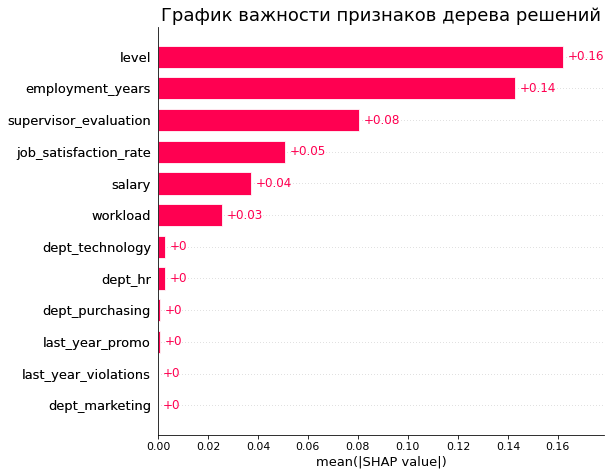

In [82]:
shap_explainer = shap.TreeExplainer(
    pipe_final_tree["models"], 
    pipe_final_tree["preprocessor"].transform(
        pipe_final_tree["imputer"].transform(X_test)
    )
)

shap_values = shap_explainer(pd.DataFrame(
    pipe_final_tree["preprocessor"].transform(
        pipe_final_tree["imputer"].transform(X_test)
    ),
    columns = (
        pipe_final_tree["preprocessor"].transformers_[0][1].get_feature_names_out().tolist() +
        qual_columns[1:] + quant_columns + target_column_job
    )
))

shap.plots.bar(shap_values[:,:,1], max_display=12, show=False)
plt.title("График важности признаков дерева решений", size=18)
plt.show()

Для данной модели самыми важными являются признаки уровня должности и время работы в компании, следующим идет признак оценки руководителя и только на четвертом месте по важности является уровень удовлетворенности. Далее идут признаки уровня заработной платы и нагрузки.

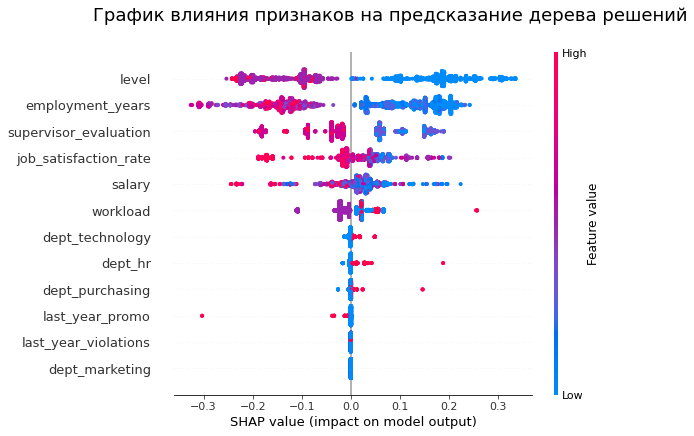

In [83]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=12, show=False)
plt.suptitle("График влияния признаков на предсказание дерева решений", size=18)
plt.show()

По влиянию признаков заметно, что более низкий уровень должности, малый срок работы и низкая оценка руководителя оказывают один из решающих факторов. Уровень удовлетворенности показывает достаточно разнонаправленную влияние по данной модели, но чем он выше, тем ниже вероятность увольнения. Уровень заработной платы и нагрузки также имеет достаточно смешанное влияние.

#### Логистическая регрессия

In [84]:
# как раз у меня StandardScaler стоит по умолчанию в preprocessor'е

pipe_final_log = Pipeline([
    ("imputer", imputer_pipe),
    ('preprocessor', data_prep_quit),
    ('models', LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear', C=4,
        class_weight='balanced'
    ))
])

pipe_final_log.fit(X_train, y_train)

# ROC-AUC тестовой выборки
target_quit_proba = pipe_final_log.predict_proba(X_test)
print(
    "\nМетрика ROC-AUC для тестовой выборки:",
    round(
        roc_auc_score(y_test, target_quit_proba[:,1]),
        3
    )
)


Метрика ROC-AUC для тестовой выборки: 0.894


Метрика на тестовой выборке не достигает целевого показателя. Возможно поможет отбор параметров

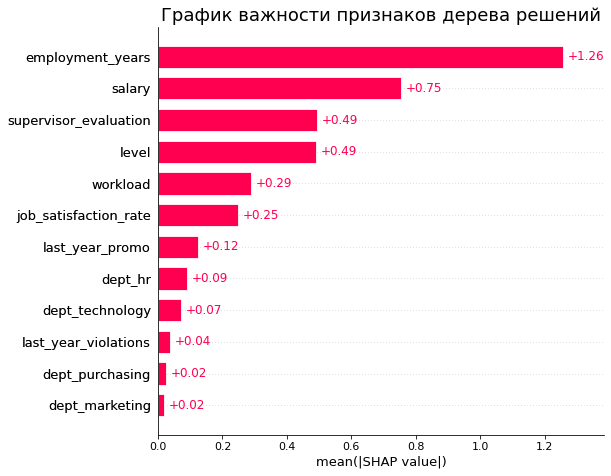

In [85]:
shap_explainer = shap.LinearExplainer(
    pipe_final_log["models"], 
    pipe_final_log["preprocessor"].transform(
        pipe_final_log["imputer"].transform(X_test)
    )
)

shap_values = shap_explainer(pd.DataFrame(
    pipe_final_log["preprocessor"].transform(
        pipe_final_log["imputer"].transform(X_test)
    ),
    columns = (
        pipe_final_log["preprocessor"].transformers_[0][1].get_feature_names_out().tolist() +
        qual_columns[1:] + quant_columns + target_column_job
    )
))

shap.plots.bar(shap_values, max_display=12, show=False)
plt.title("График важности признаков дерева решений", size=18)
plt.show()

Для линейной регрессии наиболее важными являются признаки времени работы и зарплаты, далее по важности идут оценка руководителя и уровень должности. Уровень удовлетворенности располагается после уровня нагрузки. Самыми низкими по важности идут отдел и наличие нарушений за последний год.

In [86]:
# Пайплайн для ORD кодирования
ord_pipe_trunc = Pipeline([
    ("ord", OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'sinior'],
            ['low', 'medium', 'high'],
            ['no', 'yes'],
            #['no', 'yes']
        ]
    ))
])

# Общий пайплайн для подготовки данных
data_prep_trunc = ColumnTransformer([
    #("ohe", ohe_pipe, ['dept']),
    ("ord", ord_pipe_trunc, [
        'level', 
        'workload', 
        'last_year_promo', 
        #'last_year_violations'
    ]),
    ("num", RobustScaler(), [
        'employment_years', 
        'supervisor_evaluation', 
        'salary', 
        'job_satisfaction_rate'])
])

pipe_final_trunc = Pipeline([
    ("imputer", imputer_pipe),
    ('preprocessor', data_prep_trunc),
    ('models', LogisticRegression(
        C=2, class_weight='balanced',
        random_state=RANDOM_STATE, solver='liblinear'
    ))
])

pipe_final_trunc.fit(X_train, y_train)

# ROC-AUC тестовой выборки
target_quit_proba = pipe_final_trunc.predict_proba(X_test)
print(
    "\nМетрика ROC-AUC для тестовой выборки:",
    round(
        roc_auc_score(y_test, target_quit_proba[:,1]),
        3
    )
)


Метрика ROC-AUC для тестовой выборки: 0.895


Отбор признаков совершенно незначительно повысил значение метрики. По мере исключения параметров отдела и наличия нарушений трудового договора метрика модели росла. Исключение других признаков приводило к снижению метрики ROC-AUC.

#### SVM

Целевое значение метрики достигнуто, однако высокие показатели логистической регрессии на кросс-валидации говорят о наличии линейной зависимости в данных, однако по результатам исследовательского анализа заметно, что также имеются нестандартные комбинации признаков и широкое их распределение. Возможно логистическая модель обладает недостаточной робастностью для более точного предсказания. Для этих целей лучше подходит метод опорных веторов. Подберем параметры для проверки данного метода.

In [87]:
# Все-таки решил добавить SVM
# Подбрал параметры так, чтобы при малом количестве итераций получить
# модель с более высокими знчениями метрики ROC-AUC

param_grid_svm = [
    # словарь для модели SVM
    {
        'models': [SVC(random_state=RANDOM_STATE, class_weight='balanced', probability=True)],  
        'models__kernel': ['rbf', 'poly'],
        "models__C": range(5, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

search_cv_svm = RandomizedSearchCV(
    pipe_final_quit, param_grid_svm, 
    cv=5, scoring='roc_auc',
    n_jobs=-1, n_iter=3,
    random_state=RANDOM_STATE,
    error_score="raise"
)

start = time.time()

search_cv_svm.fit(X_train, y_train)

print(f"Время поиска модели: {(time.time() - start):0.2f}\n")
print('Лучшая модель и её параметры:')
display(search_cv_svm.best_estimator_)
print (f'Метрика лучшей модели после кросс-валидации:{search_cv_svm.best_score_:0.3f}')

# ROC-AUC тестовой выборки
target_quit_proba = search_cv_svm.predict_proba(X_test)
print(
    "\nМетрика ROC-AUC для тестовой выборки:",
    round(
        roc_auc_score(y_test, target_quit_proba[:,1]),
        3
    )
)

Время поиска модели: 16.92

Лучшая модель и её параметры:


Pipeline(steps=[('imputer',
                 Pipeline(steps=[('imputer',
                                  KnnImputer(categories=[['sales', 'purchasing',
                                                          'hr', 'marketing',
                                                          'technology'],
                                                         ['junior', 'middle',
                                                          'sinior'],
                                                         ['low', 'medium',
                                                          'high'],
                                                         ['no', 'yes'],
                                                         ['no', 'yes']],
                                             string_cols=['dept', 'level',
                                                          'workload',
                                                          'last_year_promo',
                                                          'last_year_violations']))])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrou...
                                                                                               'high'],
                                                                                              ['no',
                                                                                               'yes'],
                                                                                              ['no',
                                                                                               'yes']])),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('num', MinMaxScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate'])])),
                ('models',
                 SVC(C=9, class_weight='balanced', probability=True,
                     random_state=42))])

Метрика лучшей модели после кросс-валидации:0.937

Метрика ROC-AUC для тестовой выборки: 0.917


Модель SVM продемонстрировала лучшее значение метрики ROC-AUC по результатам кросс-валидации, а на тестовой выборке одинаковое значение с моделью дерева решений, вероятно лучшей моделью является SVM с параметром C=9.

#### Промежуточные выводы

Проведено обучение моделей для прогнозирования увольнения сотрудников:
1. Наилучшей моделью по метрике ROC-AUC является модель Метод опорных векторов (SVM) с ядром rbf и параметром C=9, среднее значение метрики после кросс-валидации составляет 0.937, на тестовой выборке - 0.917;
2. Также высокие результаты показала модель с параметрами max_depth=5 и max_features=14, среднее значение метрики ROC-AUC после кросс-валидации составляет 0.923, на тестовой выборке - 0.917;
3. Высокие значения метрики ROC-AUC после кросс-валидации показала модель дерева решений - 0.923, однако на тестовой выборке целевой показатель не достигнут.
4. Наихудшие результаты показала модель логистической регрессии, не достигнув целевого показателя при кросс-валидации.

В исходных данных имеется достаточно высокая корреляция признаков, однако присутствует довольно существенный разброс. Вероятно поэтому линейной модели не удалось достичь более высоких показателей, так как данная модель обладает недостаточной робастностью - устойчивостью к выбросам и аномалиям. Модель k ближайших соседей показала достаточно высокую метрику при кросс-валидации, однако на тестовой выборке не достигла целевого значения, возможно сказалось переобучение.

## Выводы

Задачами проекта была подготовка моделей машинного обучения для:
1. предсказания уровня удовлетворённости сотрудника. Критерий успешности: SMAPE ≤ 15 на тестовой выборке.
2. предсказания увольнения сотрудника из компании. Критерий успешности: ROC-AUC ≥ 0.91 на тестовой выборке

**По задаче 1**

Проведена загрузка исходных данных, данные разделены на три файла:

1. Тренировочная выборка с данными по результатам опроса сотрудников. Данные содержат 4000 записей, по 10 признаков для каждой. Имеются пропуски по признаку `dept` - 6 значений и признаку `level` 4 значения.
2. Тестовая выборка с аналогичными данными по сотрудникам без целевого признака. Данные содержат 2000 записей. Также имеются пропуски по признаку `dept` - значения и признаку `level` - 1 значение.
3. Целевое значение тестовой выборки с уровнем удовлетворенности сотрудников - 2000 записей. Пропуски отсутствуют.

Проведена предобработка данных, в рамках которой:
1. Явные и скрытые дубликаты, а также аномальные значения не обнаружены.
2. Выявлена опечатка по признаку `level` - некорректно записано значение `sinior`, необходимо данный вопрос отработать, так как в случае исправления опечатки в будущем, модели не будут адекватно воспринимать исправленное значение. В настоящем проекте значение оставлено как есть. При необходимости изменения исправить константу `LEVEL`.
3. Произведено заполнение пропущенных значений посредством пайплайна на основе метода k ближайших соседей.

Проведен исследовательский и корреляционный анализ тренировочной выборки. По результатам анализа можно выделить следующее:
1. Целевым являет непрерывный количественный признак уровня удовлетворенности работой в компании, соответственно перед моделью стоит задача регрессии.
2. Имеются два бинарных признака, имеющие разнонаправленное влияние на целевой признак - повышение сотрудников за последний год и наличие у них нарушений в этот период.
3. Имеются порядковые признаки - уровень должности и рабочая нагрузка, которые лучше кодировать посредством OrdinalEncoder.
4. Мультиколлинеарность отсутствует, однако имеются признаки с достаточно высокой корреляцией - зарплата сильно коррелирует с уровенем нагрузки и уровнем занимаемой должности, целевой признак имеет высокую корреляцию с оценкой руководителя, а также заметная кореляция между признаками время работы в компании и уровень занимаемой должности.
5. Количество категориальных признаков достаточно большое.

Для подготовки данных создан пайплайн:
1. Заполнение пропущенных значений посредством метода k ближайших соседей;
2. OHE кодирование категориального признака отдела `dept`;
3. Ordinal кодирование остальных категориальных признаков;
4. Масштабирование остальных некатегориальных признаков;
5. Модель машинного обучения для задачи регрессии.

Произведен автоматизированный поиск наилучшей модели:
1. Выбраны две модели - линейная регрессия и дерево решений, в качестве метрики определено SMAPE (симметричное среднее абсолютное процентное отклонение)
2. Критерием успеха модели установлено значение SMAPE ≤ 15 на тестовой выборке, по результатам автоматизированно поиска модели наилучшей оказалась модель дерева решений с максимальной глубиной 24, минимальным количеством листьев равным 2 и минимальным количеством выборок для разделения - 7, значение SMAPE составляет 13.642.

Вероятно причиной лучшего результата модели дерева решений является наличие довольно большого количества категориальных признаков по отношению к количественным.

**По задаче 2**

Произведена загрузка данных по второй задаче:
1. Количество записей в тренировочной выборке - 4000, пропуски отсутствуют.
2. Тестовая выборка для второй задачи та же, что была для первой.
3. Целевой признак тестовой выборки содержит 2000 значений, пропуски отсутствуют.

Произведена загрузка тренировочной выборки и целевого признака тестовой выборки, остальные признаки тренировочной выборки загружены ранее.
1. Количество записей тренировочной выборки составляет 4000, пропуски отсутствуют. В датасете отсутствуют данные, которые имели пропуски в первой задче;
2. Количество записей тестовой выборки составляет 2000, датасет с основными признаками из первой задчи, пропуски имелись только в датасете первой задачи, по целевому признаку пропуски отсутствуют. Расхождений в данных не выявлено, все сотрудники имеются в датасете с целевым признаком.

Проведен исследовательский анализ тренировочной выборки, по результатам которого можно определить портрет типового уволившегося сотрудника: 
1. сотрудник уровня `junior` из отдела `sales` или `technology`, имеющий низкий или реже средний уровень нагрузки;
2. сотрудник с более низким уровне заработной платы, среднее значение которой составляет 22'800 против 34'800 для неуволившихся сотрудников.
3. сотрудник работает в компании около 1-2 лет, не имеет повышений за последний год и вероятнее всего допустил нарушение трудового договора.
4. средняя оценка руководителя качества работы такого сотрудника около 3-х в отличие от неуволившихся сотрудников, оценка которых в среднем составляет 4 балла.

Также проведено исследование зависимости факта увольнения сотрудника от уровня удовлетворености работой в компании. Средняя удовлетворенность работой в компании уволенного сотрудника более низкая - 0.37 в отличие от остальных работников, средний уровень удовлетворенности которых составляет 0.66. Половина уволившихся сотрудников имела уровнь удовлетворенности от 0.24 до 0.49, тогда как у остальных сотрудников этот промежуток составляет от 0.5 до 0.76. Это говорит о том, что уровень удовлетворенности может оказывать достаточное влияние на фактор увольнения сотрудника.

В тренировочную и тестовую выборки добавлены результаты предсказания лучшей модели уровня удовлетворенности сотрудника работой в компании из задачи 1.

Пайплайн подготовки данных для модели предсказания увольнения работника дополнен признаком уровня удовлетворенности сотрудника работой в компании.

Проведено обучение моделей для прогнозирования увольнения сотрудников:
1. Наилучшей моделью по метрике ROC-AUC является модель Метод опорных векторов (SVM) с ядром rbf и параметром C=9, среднее значение метрики после кросс-валидации составляет 0.937, на тестовой выборке - 0.917;
2. Также высокие результаты показала модель с параметрами max_depth=5 и max_features=14, среднее значение метрики ROC-AUC после кросс-валидации составляет 0.923, на тестовой выборке - 0.917;
3. Высокие значения метрики ROC-AUC после кросс-валидации показала модель дерева решений - 0.923, однако на тестовой выборке целевой показатель не достигнут.
4. Наихудшие результаты показала модель логистической регрессии, не достигнув целевого показателя при кросс-валидации.

В исходных данных имеется достаточно высокая корреляция признаков, однако присутствует довольно существенный разброс. Вероятно поэтому линейной модели не удалось достичь более высоких показателей, так как данная модель обладает недостаточной робастностью - устойчивостью к выбросам и аномалиям. Модель k ближайших соседей показала достаточно высокую метрику при кросс-валидации, однако на тестовой выборке не достигла целевого значения, возможно сказалось переобучение.

**Результаты Проекта:**

1. Подготовлена модель для предсказания уровня удовлетворённости сотрудника - дерево решений с глубиной 24, минимальным количеством листьев равным 2 и минимальным количеством выборок для разделения - 7, значение SMAPE составляет 13.642.
2. Подготовлена модель для предсказания увольнения сотрудника из компании - Метод опорных векторов (SVM) с ядром rbf и параметром C=9, значение метрики ROC-AUC на тестовой выборке - 0.917.